In [9]:
import os
import os.path as osp
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

import wandb

In [10]:
from pathlib import Path
import pyrootutils

notebook_path = Path(os.path.abspath(""))
pyrootutils.setup_root(notebook_path, indicator=".project-root", pythonpath=True)

DIRNAME = r"/cluster/home/vjimenez/adv_pa_new/results"

In [11]:
def retrieve_from_history(run, keyname):
    return [row[keyname] for row in run.scan_history(keys=[keyname]) if row[keyname] is not None]

In [12]:
def adv_pa_test(
        project: str,
        group: str,
        attack: str,
        filters: dict,
        defense: str = None,
        dirname: str = "results",
        cache: bool = False,
    ) -> pd.DataFrame:

    if defense == None:
        defense = group

    api = wandb.Api(timeout=100)
    runs = api.runs(project, filters)

    pathdir = osp.join(dirname, group)
    fname = osp.join(pathdir, f"def={defense}_att={attack}.pkl")
    os.makedirs(dirname, exist_ok=True)

    if cache and osp.exists(fname):
        return pd.read_pickle(fname)

    data = defaultdict(list)
    for i, run in tqdm(enumerate(runs), total=len(runs)):
        config = run.config
        
        # Getting attributes of the experiment -------------------------
        run_split = run.name.split("_")
        run_defense = defense
        run_attack = run_split[0].split("=")[-1]
        run_ar = run_split[1].split("=")[-1]
        run_epsilon, run_steps = None, None
        if run_attack == "GAUSSIAN":
            run_epsilon = run_split[2].split("=")[-1]
        elif run_attack == "FMN":
            run_steps = run_split[2].split("=")[-1]
        else: # PGD
            run_epsilon = run_split[2].split("=")[-1]
            run_steps = run_split[2].split("=")[-1]
        # --------------------------------------------------------------

        # Config keys
        
        # data["seed"].append(config["seed"])
        data["seed"].append(0)
        data["attack"].append(run_attack)
        data["defense"].append(run_defense)
        data["ar"].append(run_ar)
        data["epsilon"].append(run_epsilon)
        data["steps"].append(run_steps)

        # Metrics:
        try:
            data["logPA"].append(retrieve_from_history(run, f"PA(0,1)/logPA")[0])
            data["beta"].append(retrieve_from_history(run, f"PA(0,1)/beta")[0])
            data["acc_pa"].append(retrieve_from_history(run, f"PA(0,1)/acc_pa")[0])
            data["AFR_true"].append(retrieve_from_history(run, f"PA(0,1)/AFR_true")[0])
            data["AFR_pred"].append(retrieve_from_history(run, f"PA(0,1)/AFR_pred")[0])
            # data["CD"].append(retrieve_from_history(run, f"PA(0,1)/CD")[0])
            # for n in range(10):
            #     data[f"CD@{n}"].append(retrieve_from_history(run, f"PA(0,1)/CD_{n}")[0])

            # data["MMD"].append(retrieve_from_history(run, f"PA(0,1)/MMD")[0])
            # data["FID"].append(retrieve_from_history(run, f"PA(0,1)/FID")[0])
            # # data["ASS"].append(retrieve_from_history(run, f"PA(0,1)/ASS")[0])
            # data["CS"].append(retrieve_from_history(run, f"PA(0,1)/CS")[0])
            # data["KL"].append(retrieve_from_history(run, f"PA(0,1)/KL")[0])
            # data["W"].append(retrieve_from_history(run, f"PA(0,1)/W")[0])
        except Exception as e:
            print(e)
            print("\nPA(0,1) values have not been logged.")
            import ipdb; ipdb.set_trace()
            data["logPA"].append(None)
            data["beta"].append(None)
            data["acc_pa"].append(None)
            data["AFR_true"].append(None)
            data["AFR_pred"].append(None)
        
    df = pd.DataFrame(data)
    if not osp.exists(pathdir):
        os.mkdir(pathdir)
    df.to_pickle(fname)
    print(f"dataframe stored in {fname}.")
    return df

In [13]:
entity='malvai'
project='Adversarial'

def _get_attack_df(attack: str):
    defenses = ['Standard', "Engstrom2019Robustness","Wong2020Fast","Addepalli2021Towards_RN18","Wang2023Better_WRN-28-10", "BPDA"]
    dfs = []
    for defense in defenses:
        df = adv_pa_test(
            project = entity + '/' + project,
            group = defense, # model
            attack = attack,
            filters= {
                    "group": defense,
                    "$and": [{"tags": attack}, {"tags": "adam"}]
                },
            cache = True,
            dirname = r"/cluster/home/vjimenez/adv_pa_new/results/adv"
        )
        
        dfs.append(df)

    return pd.concat(dfs)

def _get_defense_df(defense: str):
    attacks = ['GAUSSIAN', "PGD", "FMN"]
    dfs = []
    for attack in attacks:
        dfs.append(
            _get_attack_df(attack)
        )
    df = pd.concat(dfs)
    return df.loc[df["defense"] == defense]

# OBTAIN BETAS

In [134]:
df_pgd = _get_attack_df("PGD")
df_fmn = _get_attack_df("FMN")

In [135]:
df_pgd_betas = df_pgd.loc[
    (df_pgd['ar'] == "1.0"),
    [   
        "attack",
        "defense",
        "beta",
        "epsilon"
    ]
]

df_fmn_betas = df_fmn.loc[
    (df_fmn['ar'] == "1.0"), # foo
    [   
        "attack",
        "defense",
        "beta",
        "epsilon"
    ]
]

In [138]:
import pickle
# df_betas = pd.concat([df_pgd_betas, df_fmn_betas], ignore_index=True)

file_path  = r"/cluster/home/vjimenez/adv_pa_new/results/adv/betas_to_plot.pkl"
# with open(file_path, 'wb') as f:
#     pickle.dump(df_betas, f)

In [139]:
with open(file_path, 'rb') as f:
    df_betas = pickle.load(f)

In [140]:
df_betas[(df_betas["attack"] == "PGD") & (df_betas["defense"] == "Standard") & (df_betas["epsilon"] == "0.0314")]["beta"].item()

0.7896016240119934

# OBTAIN KENDALL TAU

In [ ]:
order_defense = ["Standard", "Engstrom2019Robustness", "Wong2020Fast", "Wang2023Better_WRN-28-10", "Addepalli2021Towards_RN18", "BPDA"]

In [49]:
from scipy.stats import kendalltau

def compute_kendall_tau(df_tau0, df_tau1):
    tau_dict = {}
    for metric in ["logPA", "AFR_true", "AFR_pred"]:
        tau, _ = kendalltau(
            np.argsort(df_tau0[metric]),
            np.argsort(df_tau1[metric])
        )
        tau_dict[metric] = tau
    return tau_dict

In [88]:
import itertools

def pairwise_kendall_tau(df, epsilon = None):
    tau_dict = {}
    for metric in ["logPA", "AFR_true", "AFR_pred"]:
        bigtau = 0.0
        ar_list = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
        pairwise_combinations = list(itertools.combinations(ar_list, 2))
        for i, j in pairwise_combinations:
            df_tau0 = df.loc[
                (df["epsilon"] == epsilon) &
                # (~df["defense"].isin(["Standard", "BPDA"])) &
                (df["ar"] == i),
                [
                    "defense",
                    "logPA",
                    "AFR_true",
                    "AFR_pred"
                ]
            ]
            df_tau1 = df.loc[
                (df["epsilon"] == epsilon) &
                # (~df["defense"].isin(["Standard", "BPDA"])) &
                (df["ar"] == j),
                [
                    "defense",
                    "logPA",
                    "AFR_true",
                    "AFR_pred"
                ]
            ]

            tau, _ = kendalltau(
                np.argsort(df_tau0[metric]),
                np.argsort(df_tau1[metric])
            )
            bigtau += tau

        # Mean kendall tau
        tau_dict[metric] = bigtau/len(pairwise_combinations)

    return tau_dict


In [89]:
# PAIRWISE
df = _get_attack_df("PGD")
df['defense_sorted'] = pd.Categorical(df['defense'], categories=order_defense, ordered=True)
df = df.sort_values(by='defense_sorted')

tau_dict = pairwise_kendall_tau(df, epsilon="0.1255")
print(tau_dict)

{'logPA': 0.5587878787878786, 'AFR_true': 0.29696969696969694, 'AFR_pred': 0.743030303030303}


In [108]:
def one_neighbour_combinations(my_list):
    result = []
    
    for i in range(len(my_list)):
        neighbors = []
        if i > 0:
            neighbors.append((my_list[i], my_list[i-1]))
        if i < len(my_list) - 1:
            neighbors.append((my_list[i], my_list[i+1]))
        result.append(neighbors)
    return result

def neighbourwise_kendall_tau(df, epsilon = None):
    tau_dict = {}
    for metric in ["logPA", "AFR_true", "AFR_pred"]:
        bigtau = 0.0
        ar_list = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
        neighbour_combinations = one_neighbour_combinations(ar_list)
        for neighbour in neighbour_combinations:
            smalltau = 0.0
            for i, j in neighbour:
                df_tau0 = df.loc[
                    (df["epsilon"] == epsilon) &
                    (~df["defense"].isin(["Standard", "BPDA"])) &
                    (df["ar"] == i),
                    [
                        "defense",
                        "logPA",
                        "AFR_true",
                        "AFR_pred"
                    ]
                ]
                df_tau1 = df.loc[
                    (df["epsilon"] == epsilon) &
                    (~df["defense"].isin(["Standard", "BPDA"])) &
                    (df["ar"] == j),
                    [
                        "defense",
                        "logPA",
                        "AFR_true",
                        "AFR_pred"
                    ]
                ]

                tau, _ = kendalltau(
                    np.argsort(df_tau0[metric]),
                    np.argsort(df_tau1[metric])
                )
                smalltau += tau
            bigtau += smalltau/len(neighbour)

        # Mean kendall tau
        tau_dict[metric] = bigtau/len(neighbour_combinations)

    return tau_dict

In [109]:
# NEIGHBOURWISE
df = _get_attack_df("PGD")
df['defense_sorted'] = pd.Categorical(df['defense'], categories=order_defense, ordered=True)
df = df.sort_values(by='defense_sorted')

tau_dict = neighbourwise_kendall_tau(df, epsilon="0.1255")
print(tau_dict)

{'logPA': 0.7121212121212122, 'AFR_true': 0.9090909090909093, 'AFR_pred': 0.6363636363636364}


In [132]:
def maximum_kendall_tau(df, epsilon = None):
    tau_dict = {}
    ar_list = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']
    for metric in ["logPA", "AFR_true", "AFR_pred"]:
        df_tau0 = df.loc[
            (df["epsilon"] == epsilon) &
            # (~df["defense"].isin(["Standard", "BPDA"])) &
            (df["ar"] == "1.0"),
            [
                "defense",
                "logPA",
                "AFR_true",
                "AFR_pred"
            ]
        ]

        all_tau = []
        for ar in ar_list:
            df_tau1 = df.loc[
                (df["epsilon"] == epsilon) &
                # (~df["defense"].isin(["Standard", "BPDA"])) &
                (df["ar"] == ar),
                [
                    "defense",
                    "logPA",
                    "AFR_true",
                    "AFR_pred"
                ]
            ]

            tau, _ = kendalltau(
                np.argsort(df_tau0[metric]),
                np.argsort(df_tau1[metric])
            )
            all_tau.append(tau)

        # Mean kendall tau
        tau_dict[metric] = np.argmax(all_tau)
    return tau_dict

In [133]:
# NEIGHBOURWISE
df = _get_attack_df("PGD")
df['defense_sorted'] = pd.Categorical(df['defense'], categories=order_defense, ordered=True)
df = df.sort_values(by='defense_sorted')

tau_dict = maximum_kendall_tau(df, epsilon="0.1255")
print(tau_dict)

{'logPA': 9, 'AFR_true': 6, 'AFR_pred': 2}


In [85]:
df = _get_attack_df("FMN")
df['defense_sorted'] = pd.Categorical(df['defense'], categories=order_defense, ordered=True)
df = df.sort_values(by='defense_sorted')

# epsilon = "0.0314"

df_tau0 = df.loc[
    # (df["epsilon"] == epsilon) &
    (~df["defense"].isin(["Standard", "BPDA"])) &
    (df["ar"] == "0.5"),
    [
        "defense",
        "logPA",
        "AFR_true",
        "AFR_pred"
    ]
]
df_tau1 = df.loc[
    # (df["epsilon"] == epsilon) &
    (~df["defense"].isin(["Standard", "BPDA"])) &
    (df["ar"] == "1.0"),
    [
        "defense",
        "logPA",
        "AFR_true",
        "AFR_pred"
    ]
]

In [86]:
# IF we only want with AFR_pred at the end:
df_tau1["AFR_true"] = df_tau1["AFR_pred"]
df_tau1["logPA"] = df_tau1["AFR_pred"]

In [87]:
compute_kendall_tau(df_tau0, df_tau1)

{'logPA': 0.6666666666666669, 'AFR_true': 0.3333333333333334, 'AFR_pred': 1.0}

In [70]:
df_tau0, df_tau1

(                     defense       logPA  AFR_true  AFR_pred
 5     Engstrom2019Robustness -155.362656    0.8212    0.9784
 5               Wong2020Fast -166.098465    0.8220    0.9780
 5   Wang2023Better_WRN-28-10 -109.201981    0.9052    0.9844
 5  Addepalli2021Towards_RN18 -194.547089    0.7760    0.9828,
                      defense       logPA  AFR_true  AFR_pred
 0     Engstrom2019Robustness -254.760941    0.8020    0.9560
 0               Wong2020Fast -237.732498    0.8016    0.9536
 0   Wang2023Better_WRN-28-10 -157.743408    0.8924    0.9712
 0  Addepalli2021Towards_RN18 -225.444672    0.7588    0.9644)

# GETTING RESULTS FOR TABLES

In [6]:
df = _get_attack_df("FMN")

In [62]:
df["defense"].unique()

array(['Standard', 'Engstrom2019Robustness', 'Wong2020Fast',
       'Addepalli2021Towards_RN18', 'Wang2023Better_WRN-28-10', 'BPDA'],
      dtype=object)

In [7]:
df_table = df.loc[
    (df["epsilon"] == "0.0627") &
    (~df["defense"].isin(["Standard", "BPDA"])) &
    (df["ar"].isin(["0.8"])),
    # (df["defense"] == "BPDA"),
    [
        "defense",
        "ar",
        # "beta",
        "logPA",
        "AFR_pred",
        "AFR_true",
    ]
]

# Engstrom2019Robustness, Wong2020Fast, Addepalli2021Towards_RN18, Wang2023Better_WRN-28-10
# BPDA, Standard

In [8]:
df_table

,defense,ar,logPA,AFR_pred,AFR_true
10,Standard,0.0,-10.084785,1.0,0.9380
10,Engstrom2019Robustness,0.0,-89.199020,1.0,0.8396
10,Wong2020Fast,0.0,-91.471809,1.0,0.8420
10,Addepalli2021Towards_RN18,0.0,-169.450500,1.0,0.7916
10,Wang2023Better_WRN-28-10,0.0,-77.827957,1.0,0.9196
10,BPDA,0.0,-209.997116,1.0,0.7884


In [14]:
import matplotlib.lines as mlines
import matplotlib.font_manager as fm

from typing import Optional, Union
import seaborn as sns
import matplotlib.font_manager as fm
from src.plot.adv import DASHES_DICT, COLORS_DICT, LABEL_DICT, YEARS

In [15]:
fontname = "DejaVu Serif"
_ = fm.findfont(fm.FontProperties(family=fontname))

df = pd.read_csv('temporal.csv')
df['ar'] = df['ar'].astype(float)

metric = "AFR_true"



LABEL_DICT = {
            "Standard": "Undefended",
            "Engstrom2019Robustness": "Engstrom et al.",
            "Wong2020Fast": "Wong et al.",
            "Addepalli2021Towards_RN18": "Addepalli et al.",
            "Wang2023Better_WRN-28-10": "Wang et al.", 
            "BPDA": "Athalye et al."
}

METRIC_DICT = {
    "FID": "FID",
    "CD": "Centroid Distance",
    "MMD": "Maximum Mean Discrepancy",
    "CS": "Cosine Similarity",
    "KL": "Kullback-Leibler Divergence",
    "W": "Wasserstein Distance",
    "acc_pa": "Accuracy",
    "AFR_true": r"AFR$_{\operatorname{T}}$",
    "AFR_pred": r"AFR$_{\operatorname{P}}$",
    "AFR_true_diff": r"$\Delta$% AFR",
    "beta": r"$\beta$"
}


# Get the font
fontname = "DejaVu Serif"
_ = fm.findfont(fm.FontProperties(family=fontname))

# Create a line plot for PGD attack type with Seaborn
_, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
# _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
sns.set(font_scale=1.9)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = fontname
sns.set_style("ticks")

sns.lineplot(
    data=df,
    ax=ax,
    x="ar",
    y=metric,
    hue="defense",
    style="defense",
    palette=COLORS_DICT,
    dashes=False,
    marker="o",
    linewidth=3,
    legend=False
)

ax.minorticks_on()
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

ax.set_xlabel("Adversarial Ratio", fontname=fontname)
# r"$10^{-4} \times $ PA"
ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
ax.set_yscale("linear") 
ax.set_title("FMN attack", fontname=fontname)



# ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.tick_params(axis="both", which="both", direction="in")
plt.xticks(rotation=45)
xticks_font = fm.FontProperties(family=fontname)
for tick in ax.get_xticklabels():
    tick.set_fontproperties(xticks_font)

ax.grid(linestyle="--")


plt.tight_layout()
fname = osp.join(
    r"/cluster/home/vjimenez/adv_pa_new/results/adv", 
    f"FMN_AFR_true_nopercentile.png"
)
plt.savefig(fname)
plt.clf()
plt.show()
plt.close()


<Figure size 772.2x545.82 with 0 Axes>

# PLOTTING THE LEGEND

In [5]:
import matplotlib.lines as mlines
import matplotlib.font_manager as fm

fontname = "DejaVu Serif"
_ = fm.findfont(fm.FontProperties(family=fontname))

LEGEND = {
    "Undefended": mlines.Line2D([], [], color='tab:orange', linewidth=3),
    "Engstrom et al.": mlines.Line2D([], [], color='tab:blue', linewidth=3),
    "Athalye et al.": mlines.Line2D([], [], color='tab:green', linewidth=3),
    "Wong et al.": mlines.Line2D([], [], color='tab:red', linewidth=3),
    "Addepalli et al.": mlines.Line2D([], [], color='tab:purple', linewidth=3),
    "Wang et al.": mlines.Line2D([], [], color='tab:brown', linewidth=3),
}   

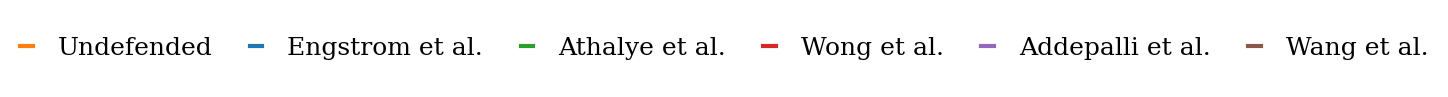

In [6]:
fig_legend = plt.figure(figsize=(12, 1))
fig_legend.legend(
    handles=LEGEND.values(),
    labels=LEGEND.keys(),
    loc='center',
    ncol=6,  # Ensure the same number of columns
    frameon=False,
    handletextpad=1.0,
    columnspacing=1.5,
    handlelength = 0.5,
    # title="Adversarial Ratio",
    prop = {
        "family": fontname,
        'size': 18
    }
)
plt.axis('off')

# Save the legend as a PNG file
# fig_legend.savefig("legend_horizontal_noframe.pdf", bbox_inches='tight', dpi=300, transparent=True)
# plt.close(fig_legend)
plt.show()

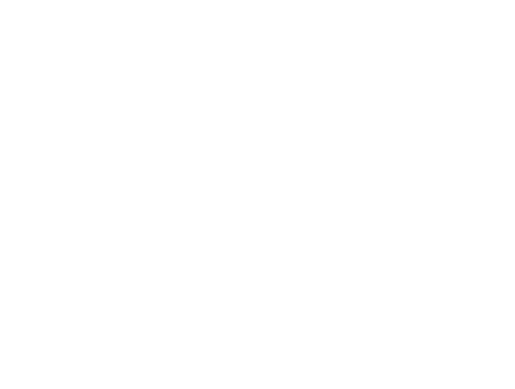

In [ ]:
# Arrange handles and labels into two columns
labels, handles = list(LEGEND.keys()), list(LEGEND.values())
handles = handles[:3] + [None] * (3 - len(handles[:3])) + handles[3:]
labels = labels[:3] + [''] * (3 - len(labels[:3])) + labels[3:]

# Create the legend figure
fig_legend = plt.figure(figsize=(12, 2))  # Adjust height to fit both columns
fig_legend.legend(
    handles=handles,
    labels=labels,
    loc='center',
    ncol=3,  # Number of columns is the maximum elements in a column
    frameon=True,
    handletextpad=1.0,
    columnspacing=1.5,
    handlelength=0.5,
    prop={
        "family": fontname,
        'size': 18
    }
)
fig_legend.savefig("legend_twocol.pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.close(fig_legend)
plt.axis('off')
plt.show()

# GETTING PLOTS

In [66]:
from typing import Optional, Union
import seaborn as sns
import matplotlib.font_manager as fm
from src.plot.adv import DASHES_DICT, COLORS_DICT, LABEL_DICT, YEARS

LABEL_DICT = {
            "Standard": "Undefended",
            "Engstrom2019Robustness": "Engstrom et al.",
            "Wong2020Fast": "Wong et al.",
            "Addepalli2021Towards_RN18": "Addepalli et al.",
            "Wang2023Better_WRN-28-10": "Wang et al.", 
            "BPDA": "Athalye et al."
}

METRIC_DICT = {
    "FID": r"FID",
    "CD": "Centroid Distance",
    "MMD": "Maximum Mean Discrepancy",
    "CS": "Cosine Similarity",
    "KL": "Kullback-Leibler Divergence",
    "W": "Wasserstein",
    "acc_pa": "Accuracy",
    "AFR_true": r"AFR$_{\operatorname{T}}$",
    "AFR_pred": r"AFR$_{\operatorname{P}}$",
    "AFR_true_diff": r"$\Delta$% AFR",
    "beta": r"$\beta$"
}

def plot_adv_ar(
        df: pd.DataFrame,
        metric: str,
        savedir: str,
        save: bool = False,
        yscale: bool = "symlog",
        ylimit: Union[tuple, list] = (None, None),
        legend: bool = True,
        version_appendix: str = ""
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Set some information based on the attack:
    attack_name = df["attack"].iloc(0)[0]
    if attack_name == "GAUSSIAN":
        attack_name_plot =  "Gaussian"
    else:
        attack_name_plot = attack_name

    if attack_name in ["PGD", "GAUSSIAN"]:
        val_name, val_column_name, plot_values = "$\ell_{\infty}$", "epsilon", [0.0314, 0.0627, 0.1255]
    elif attack_name == "FMN":
        val_name, val_column_name, plot_values = "", "steps", [""]

    for ivalue, value in enumerate(plot_values):
        for plot in ["metric", "diff"]:
            # TODO: Finish this implementation
            if plot == "diff":
                continue

            # Subset the DataFrame to include only the relevant columns and rows
            level_set = df.loc[
                (df["attack"] == attack_name),
                [
                    "ar",
                    "defense",
                    "epsilon",
                    metric,
                ],
            ]
            # Filter by epsilon if needed
            if attack_name != "FMN":
                level_set = level_set.loc[level_set["epsilon"] == str(value)]
            
            level_set['ar'] = level_set['ar'].astype(float)

            # Set theoretical to zero.
            # try:
            #     level_set.loc[level_set["ar"].eq(0.0), "logPA"] = 0.0
            # except:
            #     foo=None

            def _overall_diff(group):
                return group.iloc[-1] - group.iloc[0]

            if plot == "metric":
            
                # Create a line plot for PGD attack type with Seaborn
                _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
                # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
                sns.set(font_scale=1.9)
                plt.rcParams["font.family"] = "serif"
                plt.rcParams["font.serif"] = fontname
                sns.set_style("ticks")

                sns.lineplot(
                    data=level_set,
                    ax=ax,
                    x="ar",
                    y=metric,
                    hue="defense",
                    style="defense",
                    palette=COLORS_DICT,
                    dashes=False,
                    marker="o",
                    linewidth=3,
                    legend=legend
                )

                ax.minorticks_on()
                ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

                # ax.set_ylim(min(level_set[metric])*2, 0.5)
                ylim = ylimit if isinstance(ylimit, tuple) else ylimit[ivalue]
                ax.set_ylim(*ylim)
                ax.set_xlabel("Adversarial Ratio", fontname=fontname)
                # r"$10^{-4} \times $ PA"
                ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
                ax.set_yscale(yscale) 

                title = f"{attack_name_plot}"
                if attack_name != "FMN":
                    title += f", {val_name} = {round(value * 255):d} / 255"
                ax.set_title(title, fontname=fontname)

            else:            
                max_metric = level_set.groupby(['defense', 'ar'])[metric].max().reset_index()
                max_metric.columns = ['defense', 'ar', 'max_metric']

                level_set = level_set.sort_values(['defense', 'epsilon', 'ar'])
                level_set = level_set.groupby(['defense', 'ar'])[metric].apply(_overall_diff).reset_index()
                level_set.columns = ['defense', 'epsilon', f"{metric}_diff"]
                # level_set = level_set.sort_values(f"{metric}_diff")4

                level_set = level_set.merge(max_metric, on=['defense'])
                level_set = level_set.sort_values('max_metric', ascending=True).reset_index(drop=True)
                
                ax.bar(np.arange(len(level_set["defense"])), level_set[f"{metric}_diff"], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])  

                
                # sns.barplot(
                #     data=level_set,
                #     ax=ax,
                #     x="defense",
                #     y=f"{metric}_diff",
                #     hue="defense",
                #     palette=COLORS_DICT,
                # )
                ax.set_xticks([])
                ax.set_xticklabels([])
                # ax.get_legend().remove()

                ax.set_yscale("linear") 

                # title = r"$\Delta \ell_\infty$"
                title = r"$\Delta$ CD"

            # ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
            ax.tick_params(axis="both", which="both", direction="in")
            plt.xticks(rotation=45)
            xticks_font = fm.FontProperties(family=fontname)
            for tick in ax.get_xticklabels():
                tick.set_fontproperties(xticks_font)

            ax.grid(linestyle="--")

            ax.set_title(title if title is not None else r"$\operatorname{PA}(\mathbf{x}^\prime, \mathbf{x}^{\prime \prime}; \beta)$", fontname=fontname)

            if metric == "logPA":
                ax.text(0, 1.035, r'$\times 10^3$', transform=ax.transAxes, fontname=fontname, fontsize=18, verticalalignment='center', horizontalalignment='left')
                yticks = ax.get_yticks()[1:-1]
                ax.set_yticks(yticks)
                ax.set_yticklabels([f"{y / 1000:.1f}" for y in yticks])
                
            # Legend
            if legend == True:
                handles, labels = ax.get_legend_handles_labels()
                labels = [LABEL_DICT[label] for label in labels]
                legend_properties = {
                    "family": fontname,
                    'size': 18
                }  
                ax.legend(
                    handles,
                    labels,
                    # loc="upper right",
                    loc="lower left",
                    # fontsize=12,
                    handlelength=0.5,
                    prop=legend_properties
                )

                fig_legend = plt.figure(figsize=(4, 2))  # Adjust the size as needed
                ax_legend = fig_legend.add_subplot(111)
                ax_legend.legend(
                    handles,
                    labels,
                    loc="center",  # Center the legend in the new figure
                    handlelength=0.5,
                    prop=legend_properties
                )
                ax_legend.axis('off')
                fig_legend.savefig("legend.pdf", bbox_inches='tight')
            
            plt.tight_layout()
            if save:
                pngname = f"{attack_name}_{value}_{metric}"
                fname = osp.join(
                    savedir, 
                    pngname + version_appendix + ".pdf"
                )
                plt.savefig(fname, dpi=300)
                plt.clf()
            else:
                plt.show()
            plt.close()


In [17]:
df = _get_attack_df("PGD")

# df = df.loc[
#     (df["defense"].isin([""]))
# ]

In [65]:
df_table = df.loc[
    (df["ar"].isin(["0.0", "0.2", "0.4", "0.6"])) &
    (df["epsilon"] == "0.0627"),
    [
        "defense",
        "ar",
        "logPA",
        "AFR_pred"
    ]
]

# df_table.to_csv("foo.csv")

In [60]:
df = _get_attack_df("FMN")
# df_plot = df.loc[(df["epsilon"] == "0.5")]

In [68]:
plot_adv_ar(
    df,
    "logPA",
    yscale = "linear",
    ylimit = (None, 150), #[(None, 26.66), (None, 50), (None, 133.3)],
    save = True,
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    legend = False,
    version_appendix="_fig3"
)

In [39]:
# We can also plot the differences as a barplot:
def plot_defense_barplot(
    df,
    savedir: str,
    attack_name: str,
    metric: str = "AFR_true_diff",
    save: bool = False,
    yscale: str = "linear",
    version_appendix: str = ""
    ):

    def _overall_diff(group):
        return group.iloc[-1] - group.iloc[0]

    dfplot = df.copy()
    if metric == "AFR_true_diff":
        dfplot["ar"] = df["ar"].astype(float)
        # df.loc[:, "ar"] = df["ar"].astype(float)

        # For PGD:
        # dfplot = dfplot.sort_values(['defense', 'epsilon', 'ar'])
        # dfplot = dfplot.groupby(['defense', 'epsilon'])['AFR_true'].apply(_overall_diff).reset_index()
        # dfplot.columns = ['defense', 'epsilon', 'AFR_true_diff']
        # dfplot = dfplot.sort_values('AFR_true_diff')

        # For FMN:
        dfplot = dfplot.sort_values(['defense', 'ar'])
        dfplot = dfplot.groupby(['defense'])['AFR_true'].apply(_overall_diff).reset_index()
        dfplot.columns = ['defense', 'AFR_true_diff']
        dfplot = dfplot.sort_values('AFR_true_diff')

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    for epsilon, epsval in zip(
        ["0.0314", "0.0627", "0.1255"],
        [8,16,32]
        ):

        # level_set = dfplot[dfplot["epsilon"] == epsilon]
        level_set = dfplot

        # Create a line plot for PGD attack type with Seaborn
        _, ax = plt.subplots(figsize=(1.4 * 3.861, 2 * 2.7291))
        # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")

        # Create x-coordinates for the bars
        x = np.arange(len(level_set))
        ax.bar(x, level_set[metric], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])

        # ax.get_legend().remove()
        ax.set_xticks([])
        ax.set_ylabel(r"$\Delta$ AFR" if metric == "AFR_true_diff" else METRIC_DICT[metric], fontname=fontname)
        ax.set_yscale(yscale)
        ax.set_xlabel(None)
        ax.minorticks_on()
        ax.grid(linestyle="--")

        # title = fr"AR = 0.1"
        # title = fr"$\Delta$ AFR, $\ell_\infty$ = {epsval} / 255"
        # title = r"$\Delta$ AFR"
        title = fr"AR = 0.5"
        # title = fr"AR = 1.0, $\ell_\infty$ = {epsval} / 255"
        # title = "FMN"
        ax.set_title(title, fontname=fontname)
        plt.tight_layout()
        if save:
            if attack_name == "PGD":
                fname = f"PGD_{metric}_barplot_eps={epsilon}{version_appendix}.pdf"
            else:
                fname = f"FMN_{metric}_barplot_{version_appendix}.pdf"

            # fname = f"{metric}_barplot_FMN_0.1.png"
            plt.savefig(os.path.join(savedir, fname), dpi=300)
            plt.clf()
        else:
            plt.show()
        plt.close()

In [40]:
attack_name = "FMN"
df = _get_attack_df(attack_name)
df_plot = df[
    (df["ar"] == "0.5")# & (df["epsilon"] == "0.0314") 
] 

In [41]:
# df_plot.loc[df_plot["defense"] == "Wong2020Fast", "W"] = 0.0000027
# df_plot = df_plot.sort_values(by='W', ascending=True)

# df_plot  = _get_attack_df("PGD")

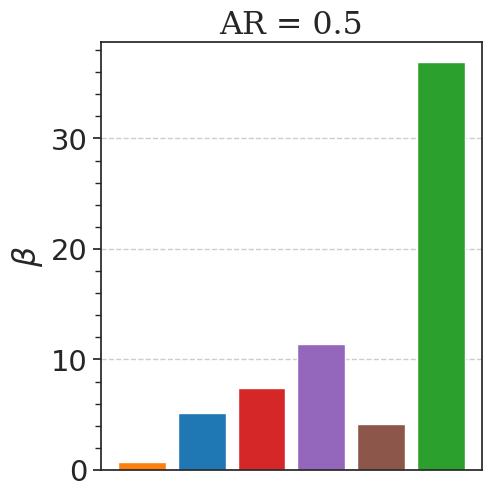

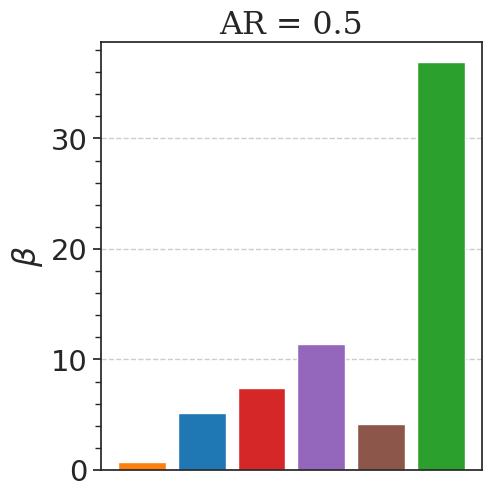

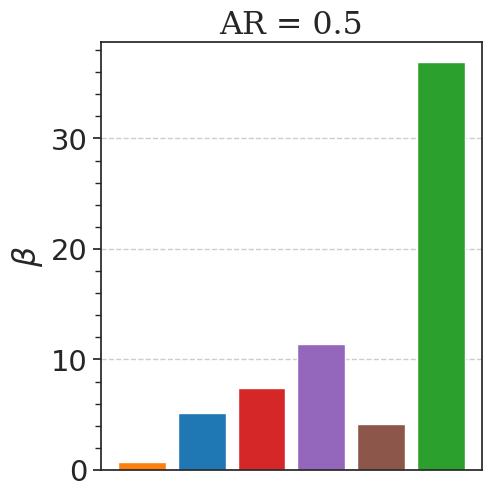

In [42]:
plot_defense_barplot(
    df_plot,
    metric = "beta",
    attack_name=attack_name,
    save = False,
    yscale = "linear",
    version_appendix = "0.5",
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
)

In [1]:
def plot_sameattack_ar(
        df: pd.DataFrame,
        metric: str,
        epsilon: float,
        savedir: str,
        yscale: bool = "symlog",
        legend: bool = True,
        save: bool = False,
        version_appendix: str = ""
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Set some information based on the attack:
    attack_name = df["attack"].iloc(0)[0]
    if attack_name == "GAUSSIAN":
        attack_name_plot =  "Gaussian"
    else:
        attack_name_plot = attack_name

    if attack_name in ["PGD", "GAUSSIAN"]:
        val_name, val_column_name, plot_values = "$\ell_{\infty}$", "epsilon", [0.0314, 0.0627, 0.1255]
    elif attack_name == "FMN":
        val_name, val_column_name, plot_values = "", "steps", [""]

    # Subset the DataFrame to include only the relevant columns and rows
    level_set = df.loc[
        (df["attack"] == attack_name),
        [
            "ar",
            "beta",
            "defense",
            "epsilon",
            metric,
        ],
    ]
    # Filter by epsilon if needed
    if attack_name != "FMN":
        level_set = level_set.loc[level_set["epsilon"] == str(epsilon)]
    
    level_set['ar'] = level_set['ar'].astype(float)

    # Set theoretical to zero.
    try:
        level_set.loc[level_set["ar"].eq(0.0), "logPA"] = 0.0
    except:
        foo=None
    
    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    sns.lineplot(
        data=level_set,
        ax=ax,
        x="ar",
        y=metric,
        hue="defense",
        style="defense",
        palette=COLORS_DICT,
        dashes=False,
        marker="o",
        linewidth=3,
        legend=legend
    )

    ax.minorticks_on()
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    
    ax.tick_params(axis="both", which="both", direction="in")
    plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")

    ax.set_ylim(min(level_set[metric])*2, 0.5)
    # ax.set_ylim(min(level_set[metric])*2, 10)
    ax.set_xlabel("Adversarial Ratio", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
    ax.set_yscale(yscale) 
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()
        labels = [LABEL_DICT[label] for label in labels]
        legend_properties = {
            "family": fontname,
            'size': 18
        }  
        ax.legend(
            handles,
            labels,
            loc="upper right",
            # loc="lower left",
            # fontsize=12,
            handlelength=0.5,
            prop=legend_properties
        )

    title = f"{attack_name_plot} attack"
    if attack_name != "FMN":
        title += f", {val_name} = {round(epsilon * 255):d} / 255"
    ax.set_title(title, fontname=fontname)

    plt.tight_layout()
    if save == True:
        pngname = f"{attack_name}_{metric}"
        fname = osp.join(
            savedir, 
            pngname + version_appendix + ".png"
        )
        plt.savefig(fname)
    else:
        plt.show()
    plt.clf()
    plt.close()

NameError: name 'pd' is not defined

ValueError: cannot reindex from a duplicate axis

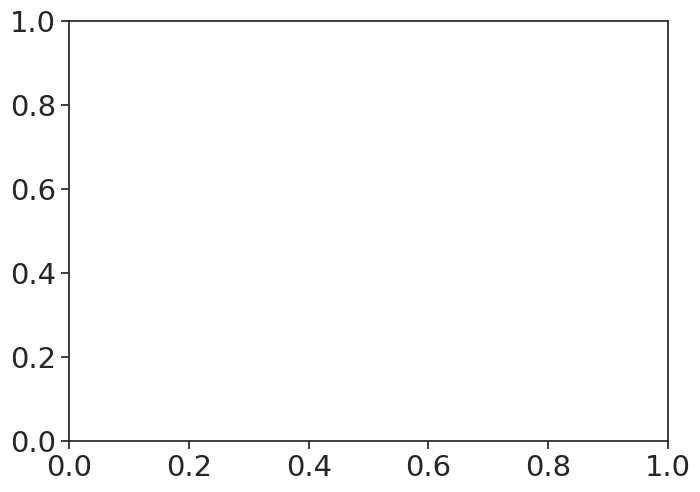

In [34]:
df = _get_attack_df("PGD")

# df_plot = df[
#     (df["attack"] == "GAUSSIAN") #& (df["defense"] != "BPDA")
# ]

plot_sameattack_ar(
    df,
    "FID",
    yscale = "linear",
    epsilon = 0.0314,
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    legend = True,
    save = False,
    version_appendix=""
)

In [35]:
LABEL_DICT_samedefense = {
            "0.0314": "$\ell_{\infty}$" + f"= {round(0.0314 * 255):d} / 255",
            "0.0627": "$\ell_{\infty}$" + f"= {round(0.0627 * 255):d} / 255",
            "0.1255": "$\ell_{\infty}$" + f"= {round(0.1255 * 255):d} / 255",
}

def plot_samedefense_ar(
        df: pd.DataFrame,
        metric: str,
        defense_name: str,
        savedir: str,
        yscale: bool = "symlog",
        legend: bool = True,
        version_appendix: str = "",
        save: bool = False
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Set some information based on the attack:
    attack_name = df["attack"].iloc(0)[0]
    if attack_name == "GAUSSIAN":
        attack_name_title =  "Gaussian"
    else:
        attack_name_title = attack_name

    df = df.loc[df["defense"] == defense_name]

    if attack_name in ["PGD", "GAUSSIAN"]:
        val_name, val_column_name, plot_values = "$\ell_{\infty}$", "epsilon", [0.0314, 0.0627, 0.1255]
    elif attack_name == "FMN":
        exit()

    # Subset the DataFrame to include only the relevant columns and rows
    level_set = df.loc[
        (df["attack"] == attack_name),
        [
            "ar",
            "beta",
            "defense",
            "epsilon",
            metric,
        ],
    ]
    level_set['ar'] = level_set['ar'].astype(float)

    # Set theoretical to zero.
    try:
        level_set.loc[level_set["ar"].eq(0.0), "logPA"] = 0.0
    except:
        foo=None
    
    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    sns.lineplot(
        data=level_set,
        ax=ax,
        x="ar",
        y=metric,
        hue="defense",
        style="epsilon",
        palette=COLORS_DICT,
        dashes=True,
        marker="o",
        linewidth=3,
        legend=legend
    )

    ax.minorticks_on()
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    ax.tick_params(axis="both", which="both", direction="in")
    plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")

    # ax.set_ylim(min(level_set[metric])*2, 0.5)
    # ax.set_ylim(min(level_set[metric])*2, 10)
    ax.set_xlabel("Adversarial Ratio", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
    ax.set_yscale(yscale) 
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()
        labels = [LABEL_DICT_samedefense[label] for label in labels]

        labels = labels[3:][::-1]
        handles = handles[3:][::-1]
        
        legend_properties = {
            "family": fontname,
            'size': 18
        }  
        ax.legend(
            handles,
            labels,
            # loc="upper right",
            loc="upper left",
            # fontsize=12,
            handlelength=0.5,
            prop=legend_properties
        )

    title = f"{attack_name_title} vs {LABEL_DICT[defense_name]}"
    ax.set_title(title, fontname=fontname)

    plt.tight_layout()
    if save == True:
        pngname = f"{attack_name}_{metric}"
        fname = osp.join(
            savedir, 
            pngname + version_appendix + ".png"
        )
        plt.savefig(fname)
        plt.clf()
        plt.close()
    else:
        plt.show()

KeyError: 'defense'

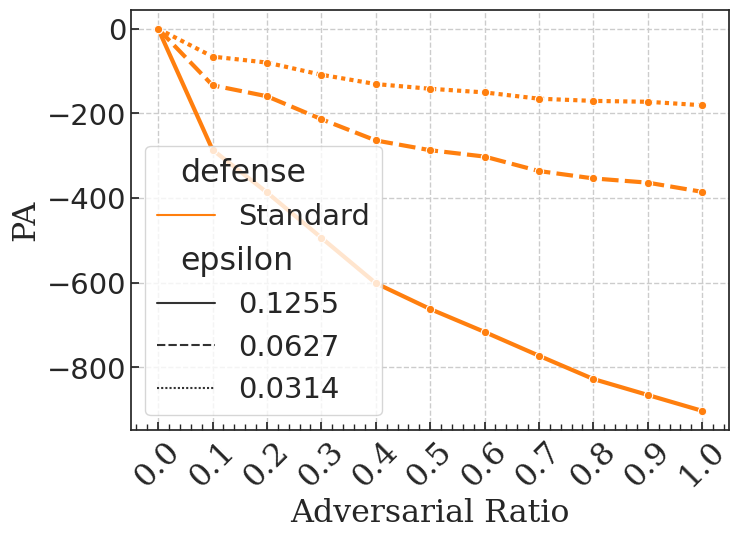

In [84]:
df_plot = _get_attack_df("GAUSSIAN")

# df_plot = df[
#     (df["attack"] == "PGD") #& (df["defense"] != "BPDA")
# ]
plot_samedefense_ar(
    df_plot,
    "logPA",
    defense_name = "Standard",
    yscale = "linear",
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    legend = True,
    version_appendix="",
    save = False
)

In [9]:
LABEL_DICT_samedefense = {
            "0.0314": f"{round(0.0314 * 255):d}",
            "0.0627": f"{round(0.0627 * 255):d}",
            "0.1255": f"{round(0.1255 * 255):d}",
}

COLORS_DICT_GAUSS = {
    "Standard": "tab:blue"
}

def plot_samedefense_epsilon(
        df: pd.DataFrame,
        metric: str,
        savedir: str,
        save: bool = False,
        yscale: bool = "symlog",
        legend: bool = True,
        version_appendix: str = ""
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """
    def _overall_diff(group):
        return group.iloc[-1] - group.iloc[0]
    
    def _percentual_diff(group):
        first_value = group.iloc[0]
        last_value = group.iloc[-1]
        return (last_value - first_value) / abs(first_value) * 100

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Set some information based on the attack:
    attack_name = df["attack"].iloc(0)[0]
    if attack_name == "GAUSSIAN":
        attack_name_title =  "Gaussian"
    else:
        attack_name_title = attack_name

    if attack_name in ["PGD", "GAUSSIAN"]:
        val_name, val_column_name, plot_values = "$\ell_{\infty}$", "epsilon", [0.0314, 0.0627, 0.1255]
    elif attack_name == "FMN":
        exit()

    # Subset the DataFrame to include only the relevant columns and rows
    level_set = df.loc[
        (df["attack"] == attack_name),
        [
            "ar",
            "defense",
            "epsilon",
            metric,
        ],
    ]
    level_set['ar'] = level_set['ar'].astype(float)

    # Set theoretical to zero.
    try:
        level_set.loc[level_set["ar"].eq(0.0), "logPA"] = 0.0
    except:
        foo=None
    
    for plot in ["metric", "difference"]:            
        width_factor = 2 if plot == "metric" else 1.4

        _, ax = plt.subplots(figsize=(width_factor * 3.861, 2 * 2.7291))
        # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")

        if plot == "metric":
            sns.lineplot(
                data=level_set,
                ax=ax,
                x="epsilon",
                y=metric,
                hue="defense",
                style="defense",
                palette=COLORS_DICT_GAUSS,
                dashes=False,
                marker="o",
                linewidth=3,
                legend=legend
            )

            # ax.set_ylim(.25, None)
            # ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
            ax.set_ylabel(r"$p$", fontname=fontname)
            ax.set_yscale(yscale) 

            ax.set_xticks(level_set["epsilon"].unique().tolist())
            ax.set_xticklabels(list(LABEL_DICT_samedefense.values())[::-1])
            ax.set_xlabel("255 $\ell_{\infty}$", fontname=fontname)

            # title = METRIC_DICT[metric]
            title = 'Gaussian attack'

        else:            
            max_metric = level_set.groupby(['defense', 'ar'])[metric].max().reset_index()
            max_metric.columns = ['defense', 'ar', 'max_metric']

            level_set = level_set.sort_values(['defense', 'epsilon', 'ar'])
            level_set = level_set.groupby(['defense', 'ar'])[metric].apply(_overall_diff).reset_index()
            level_set.columns = ['defense', 'epsilon', f"{metric}_diff"]
            # level_set = level_set.sort_values(f"{metric}_diff")4

            level_set = level_set.merge(max_metric, on=['defense'])
            level_set = level_set.sort_values('max_metric', ascending=True).reset_index(drop=True)
            
            ax.bar(np.arange(len(level_set["defense"])), level_set[f"{metric}_diff"], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])  

            
            # sns.barplot(
            #     data=level_set,
            #     ax=ax,
            #     x="defense",
            #     y=f"{metric}_diff",
            #     hue="defense",
            #     palette=COLORS_DICT,
            # )
            ax.set_xticks([])
            ax.set_xticklabels([])
            # ax.get_legend().remove()

            ax.set_yscale("linear") 

            # title = r"$\Delta \ell_\infty$"
            title = r"$\Delta$ CD"


        
        ax.tick_params(axis="both", which="both", direction="in")

        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)

        ax.grid(linestyle="--")
        ax.minorticks_on()        
        
        # Legend
        if legend == True and plot == "metric":
            handles, labels = ax.get_legend_handles_labels()
            labels = [LABEL_DICT[label] for label in labels]

            legend_properties = {
                "family": fontname,
                'size': 18
            }  
            ax.legend(
                handles,
                labels,
                # loc="upper right",
                loc="best",
                # fontsize=12,
                handlelength=0.5,
                prop=legend_properties
            )

        
        ax.set_title(title, fontname=fontname)
        ax.invert_xaxis()

        plt.tight_layout()
        if save == True:
            _diff = "" if plot == "metric" else "_diff"
            pngname = f"{attack_name}_{metric}_eps{_diff}"
            fname = osp.join(
                savedir, 
                pngname + version_appendix + ".png"
            )
            plt.savefig(fname)
            plt.clf()
        else:
            plt.show()
        plt.close()

In [48]:
df_plot = _get_attack_df("PGD")

df_plot = df_plot[
    (df_plot["ar"] == str(1.0)) & (df["defense"] == "Standard")
]

plot_samedefense_epsilon(
    df_plot,
    "logPA",
    yscale = "linear",
    save = True,
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    legend = False,
    version_appendix="_fooo"
)                                                

In [11]:
COLORS_DICT_ATTACK = {
    "GAUSSIAN": "tab:olive",
    "PGD": "tab:cyan",
    "FMN": "tab:gray",
}
LABEL_DICT_ATTACK = {
    "GAUSSIAN": f"Gaussian",
    "PGD": "PGD",
    "FMN": "FMN",
    "scatter": "Selected",
    "attack": "attack",
    "metric": "metric",
    "AFR_true": "AFR (T)",
    "AFR_pred": "AFR (P)",
}

def plot_fmn_pgd_ar(
        df: pd.DataFrame,
        defense: str,
        epsilon: float,
        vline: float,
        scatter: tuple,
        metric: str,
        savedir: str,
        yscale: bool = "symlog",
        legend: bool = True,
        version_appendix: str = ""
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Subset the DataFrame to include only the relevant columns and rows
    if metric in ["AFR_true", "AFR_pred"]:
        level_set = df.loc[
            (df["defense"] == defense),
            [
                "ar",
                "beta",
                "attack",
                "epsilon",
                "AFR_pred",
                "AFR_true"
            ],
        ]
    else:
        level_set = df.loc[
            (df["defense"] == defense),
            [
                "ar",
                "beta",
                "attack",
                "epsilon",
                metric,
            ],
        ]
    level_set = level_set.loc[
        (level_set["epsilon"] == str(epsilon)) | (level_set["epsilon"].isna())
    ]
    level_set['ar'] = level_set['ar'].astype(float)

    # Set theoretical to zero.
    try:
        level_set.loc[level_set["ar"].eq(0.0), "logPA"] = 0.0
    except:
        foo=None
    
    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    if metric in ["AFR_true", "AFR_pred"]:
        level_set_melted = pd.melt(
            level_set,
            id_vars=['ar', 'attack'], 
            value_vars=['AFR_pred', 'AFR_true'], 
            var_name='metric', value_name='value'
        )
        sns.lineplot(
            data=level_set_melted,
            x='ar',
            y='value',
            hue='attack',
            style='metric',
            palette=COLORS_DICT_ATTACK,
            dashes=True,
            markers='o',
            linewidth=3,
            ax=ax
        )
    else:
        sns.lineplot(
            data=level_set,
            ax=ax,
            x="ar",
            y=metric,
            hue="attack",
            style="attack",
            palette=COLORS_DICT_ATTACK,
            dashes=False,
            marker="o",
            linewidth=3,
            legend=legend
        )

    # We add the two values of interest:
    def _scatter_selected(attack: str, ar: float, add_label: bool = False):
        ax.scatter(
            [ar],
            level_set.loc[
                (level_set["attack"] == attack) &
                (level_set["ar"] == ar)
            ][metric].item(),
            s = 65,
            edgecolor='black',
            linewidth=3,
            facecolor='none',
            label="scatter" if add_label==True else None,
            zorder=3
        )

    def _vline_selected(ar: float, add_label: bool = False):
        ax.axvline(
            ar,
            color="black",
            linewidth=1.5,
            label="scatter" if add_label==True else None,
            linestyle="--",
            zorder=3
        )

    if scatter != None:
        _scatter_selected("PGD", scatter[0])
        _scatter_selected("FMN", scatter[1])
    if vline != None:
        _vline_selected(vline)


    ax.minorticks_on()
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    ax.tick_params(axis="both", which="both", direction="in")
    plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")

    # ax.set_ylim(min(level_set[metric])*2, 0.5)
    # ax.set_ylim(min(level_set[metric])*2, 10)
    ax.set_xlabel("Adversarial Ratio", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    if metric in ["AFR_true", "AFR_pred"]:
        ax.set_ylabel("AFR", fontname=fontname)
    else:
        ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
    ax.set_yscale(yscale) 
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()
        labels = [LABEL_DICT_ATTACK[label] for label in labels]

        # ____________________________________________________________________________________________________
        # from matplotlib.lines import Line2D
        # labels, handles = [], []
        # last_two_labels = ['AFR (T)', 'AFR (P)']
        # last_two_styles = [(0, ()), (0, (3, 1, 1, 1))] 
        # for label, style in zip(last_two_labels, last_two_styles):
        #     line = Line2D([0], [0], color='black', linestyle=style, linewidth=1.5)
        #     handles.append(line)
        #     labels.append(label)
        #_____________________________________________________________________________________________________

        
        ax.legend(
            handles,
            labels,
            # loc="upper right",
            loc="lower left",
            # fontsize=12,
            handlelength=0.5,
            prop={
                "family": fontname,
                'size': 18
            }  
        )

    title = f"{LABEL_DICT[defense]}" + ", $\ell_{\infty}$" + f" = {round(epsilon * 255):d} / 255"
    ax.set_title(title, fontname=fontname)

    plt.tight_layout()
    pngname = f"{defense}_{epsilon}_{metric}"
    fname = osp.join(
        savedir, 
        pngname + version_appendix + ".png"
    )
    plt.savefig(fname)
    plt.clf()
    plt.close()


In [12]:
LABEL_DICT = {
    "Standard": "Undefended",
    "Engstrom2019Robustness": "Engstrom et al.",
    "BPDA": "Athalye et al.",
    "Wong2020Fast": "Wong et al.",
    "Addepalli2021Towards_RN18": "Addepalli et al.",
    "Wang2023Better_WRN-28-10": "Wang et al."
}

defense = "Wang2023Better_WRN-28-10"
df_plot = _get_defense_df(defense)

df_plot = df_plot[
    (df_plot["attack"] != "GAUSSIAN") #& (df_plot["defense"] != "BPDA")
]        

In [ ]:
plot_fmn_pgd_ar(
    df_plot,
    defense=defense,
    epsilon=0.1255,
    vline=0.1,
    scatter=None,
    metric="logPA",
    yscale = "linear",
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    legend = True,
    version_appendix=""
)  

In [13]:
from typing import List

METRIC_DICT_BARPLOT = {
    "FID": "Frechet Inception Distance",
    "CD": "Centroid Distance",
    "MMD": "MMD",
    "CS": "Cosine Similarity",
    "KL": "Kullback-Leibler",
    "W": "Wasserstein",
    "acc_pa": "Accuracy",
    "AFR_true": "AFR (T)",
    "AFR_pred": "AFR (P)",
    "beta": r"$\beta$"
}

def plot_fmn_pgd_barplot(
        df: pd.DataFrame,
        defense: str,
        epsilon: float,
        vline: float,
        metrics: List[str],
        savedir: str,
        yscale: bool = "symlog",
        version_appendix: str = "",
        save: bool = False
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Subset the DataFrame to include only the relevant columns and rows
    column_list = ["ar", "attack", "epsilon"]
    column_list.extend([metric for metric in metrics])
    level_set = df.loc[
        (df["defense"] == defense),
        column_list,
    ]
    level_set = level_set.loc[
        (level_set["epsilon"] == str(epsilon)) | (level_set["epsilon"].isna())
    ]
    level_set['ar'] = level_set['ar'].astype(float)

    # Set theoretical to zero.
    try:
        level_set.loc[level_set["ar"].eq(0.0), "logPA"] = 0.0
    except:
        foo=None
    
    # Create a line plot for PGD attack type with Seaborn
    for metric in metrics:
        _, ax = plt.subplots(figsize=(3.861, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")

        ys = [
            level_set.loc[
                (level_set["attack"] == attack) &
                (level_set["ar"] == ar)
            ][metric].item()
            for attack, ar in [("PGD", vline), ("FMN", vline)]
        ]

        sns.barplot(
            data=level_set,
            x=["PGD", "FMN"],
            y=ys,
            palette=[COLORS_DICT_ATTACK[att] for att in ["PGD", "FMN"]],
        )

        # ax.tick_params(axis="both", which="both", direction="in")
        # plt.xticks(rotation=45)
        # xticks_font = fm.FontProperties(family=fontname)
        # for tick in ax.get_xticklabels():
        #     tick.set_fontproperties(xticks_font)

        # ax.grid(linestyle="--")

        # ax.set_ylim(min(level_set[metric])*2, 0.5)
        # ax.set_ylim(min(level_set[metric])*2, 10)
        # ax.set_xlabel("Adversarial Ratio", fontname=fontname)

        # r"$10^{-4} \times $ PA"

        # ax.set_ylabel(METRIC_DICT[metric], fontname=fontname)

        title = f"{METRIC_DICT_BARPLOT[metric]}"
        ax.set_title(title, fontname=fontname)

        plt.tight_layout()
        if save == True:
            pngname = f"{defense}_{epsilon}_{metric}"
            fname = osp.join(
                savedir, 
                pngname + version_appendix + ".png"
            )
            plt.savefig(fname)
        else:
            plt.show()
        plt.clf()
        plt.close()

In [ ]:
defense = "Wang2023Better_WRN-28-10"
# df_plot = _get_defense_df(defense)

df_plot.head()
df_to_show = df_plot.loc[
    (df_plot["attack"] == "PGD") &
    (df_plot["ar"] == "0.1")
]

df_to_show

In [60]:
LABEL_DICT = {
    "Standard": "Undefended",
    "Engstrom2019Robustness": "Engstrom et al.",
    "BPDA": "Athalye et al.",
    "Wong2020Fast": "Wong et al.",
    "Addepalli2021Towards_RN18": "Addepalli et al.",
    "Wang2023Better_WRN-28-10": "Wang et al."
}

defense = "Addepalli2021Towards_RN18"
df_plot = _get_defense_df(defense)

df_plot = df_plot[
    (df_plot["attack"] != "PGD") & (df_plot["ar"] != "1.0")
]   

100%|██████████| 33/33 [01:53<00:00,  3.44s/it]


dataframe stored in /cluster/home/vjimenez/adv_pa_new/results/adv/Wong2020Fast/def=Wong2020Fast_att=GAUSSIAN.pkl.


ValueError: can only convert an array of size 1 to a Python scalar

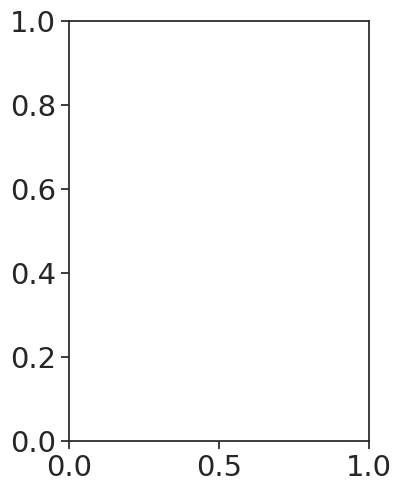

In [88]:
plot_fmn_pgd_barplot(
    df_plot,
    defense=defense,
    epsilon=0.1255,
    vline=0.1,
    metrics=["FID"], #["beta", "MMD", "FID", "CD", "CS", "KL", "W"],
    yscale = "linear",
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    version_appendix="_01",
    save = False
)  

In [12]:
import json

def _get_beta_data(
        dirname: str = "results",
        cache: bool = False,
    ) -> pd.DataFrame:

    api = wandb.Api(timeout=100)

    entity = "malvai"
    project = "Adversarial"
    group = "Standard"

    runs = api.runs(entity + "/" + project, filters={"group": group})
    run_names = [f"att=GAUSSIAN_ar={str(sr / 10)}_eps=0.1255" for sr in range(0, 11)]

    pathdir = osp.join(dirname, group)
    fname = osp.join(pathdir, f"betas_plot.pkl")
    os.makedirs(dirname, exist_ok=True)

    if cache and osp.exists(fname):
        return pd.read_pickle(fname)

    df_list = []
    for i, run in tqdm(enumerate(runs), total=len(runs)):
        data = {}
        config = run.config
        run_name = run.name
        if run_name not in run_names:
            continue

        # Config keys
        nepochs = config["callbacks/posterioragreement/pa_epochs"]
        data["seed"] =  np.full(nepochs, config["seed"]) 
        data["attack"] = np.full(nepochs, "GAUSSIAN")
        data["defense"] = np.full(nepochs, "Standard")
        data["ar"] = np.full(nepochs, run_name.split("_")[1].split("=")[-1])
        data["epsilon"] = np.full(nepochs, "0.1255")
        data["epochs"] = np.arange(1, nepochs + 1)

        def parse_wandb_table(df):
            df_dict = json.loads(",".join(df.columns.to_list()).replace('}.1,', '},'))
            return np.asarray(df_dict["data"])
        
        # Now we get the tables:
        artifacts = run.logged_artifacts()
        for artifact in artifacts:
            artifact_name = artifact.name
            table_name = artifact_name.split('-')[-1].split(':')[0][2:]
            table_name = "epoch=".join(table_name.split("epoch"))
            if table_name not in ['betas_epoch=0_table', 'logPAs_epoch=0_table']:
                continue

            # Download the artifact
            artifact_dir = artifact.download()
            files = os.listdir(artifact_dir)
            if files:
                fdir = os.path.join(artifact_dir, files[0], f"{table_name}.table.json")
                with open(fdir, "r") as f:
                    all_dict = json.load(f)

                if table_name == 'betas_epoch=0_table':
                    vardata = np.asarray(all_dict["data"])[:,1]
                    varname = "beta"
                else:
                    vardata = np.asarray(all_dict["data"])[:,2].astype(float)
                    varname = "logPA"
                data[varname] = vardata
            else:
                print(f"No files found in the artifact directory for {artifact_name}")
        
        df_list.append(pd.DataFrame(data))
    
    df = pd.concat(df_list)
    if not osp.exists(pathdir):
        os.mkdir(pathdir)
    df.to_pickle(fname)
    print(f"dataframe stored in {fname}.")
    return df

In [13]:
from matplotlib.colors import to_rgba
import matplotlib.ticker as ticker

base_color = to_rgba('tab:blue')
ar_dict = {
    str(sr / 10): (*base_color[:3], 0.3 + sr * 0.07)
    for sr in range(0, 11)
}

def plot_beta_data(
        df: pd.DataFrame,
        metric_to_plot: str,
        savedir: str,
        yscale: str = "linear",
        save: bool = False
    ):
    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Create a line plot for PGD attack type with Seaborn
    # _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    _, ax = plt.subplots(figsize=(2.5 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    sns.lineplot(
        data=df,
        ax=ax,
        x="epochs",
        y=metric_to_plot,
        hue="ar",
        style="ar",
        palette=ar_dict,
        dashes=False,
        marker="",
        linewidth=3,
        legend=False
    )

    # Colors for the legend:
    for ar, color in ar_dict.items():
        ax.plot([], [], label=ar, color=color, linewidth=3)

    # Set colorbar with adversarial ratio.
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0.3, vmax=1.0))
    sm.set_array([])  # Only needed for the colorbar
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Adversarial Ratio', fontname=fontname)
    tick_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    cbar.set_ticks([0.3, 0.3 + 0.07*2, 0.3 + 0.07*4, 0.3 + 0.07*6, 0.3 + 0.07*8, 0.3 + 0.07*10])
    cbar.set_ticklabels([f'{val:.1f}' for val in tick_values])  # Format tick labels as desired

    
    ax.set_xticks([1] + [i for i in range(20, 100 + 1, 20)])
    ax.set_xlim([0,101])
    if metric_to_plot == "logPA":
        ax.set_ylabel(r"PA", fontname=fontname)
    else:
        ax.set_ylabel(r"$\beta$", fontname=fontname)
        # ax.set_ylim([0.0, 5.0])

        # ax.set_yticks([0,1,2,3,4,5])
        # ax.set_yticklabels(["0", "1.0", "2.0", "3.0", "4.0", "5.0"])
        # ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f'))
    
    plt.xticks(rotation=45)
    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")
    ax.set_xlabel("Epochs", fontname=fontname)
    ax.set_yscale(yscale) 
    
    ax.set_title(r"Optimization of $\beta$", fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [58]:
df = _get_beta_data(
        dirname = os.path.join(DIRNAME, "adv"),
        cache = True
)

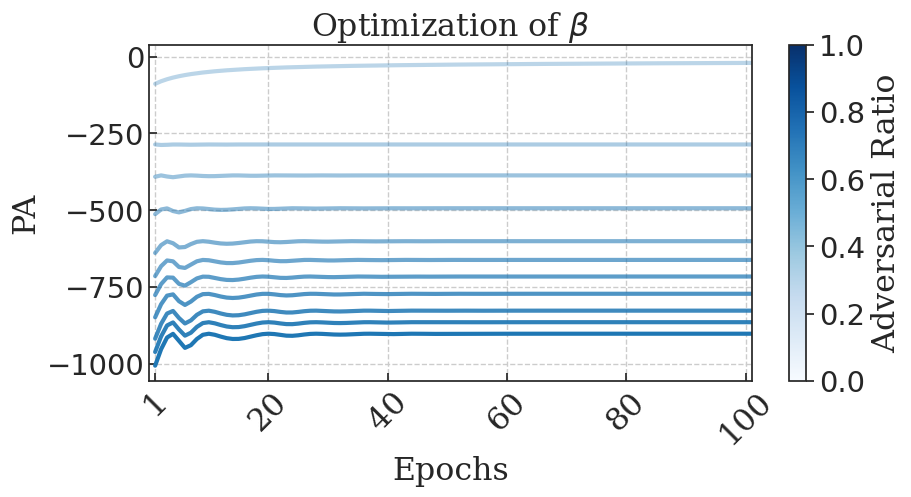

In [59]:
plot_beta_data(
    df,
    metric_to_plot="logPA",
    yscale = "linear",
    save = False,
    savedir = os.path.join(DIRNAME, "adv/Standard/logPA.png")
)

In [22]:
import pickle
import torch

def get_distribution_df(
        attack_list,
        defense_list,
        epsilon_list,
        ar: str = "1.0"
    ):
    labels_tensor = torch.arange(0,10).to(dtype=int)
    num_labels = 10

    df_list = []
    for attack, defense, epsilon in zip(attack_list, defense_list, epsilon_list):

        if attack.lower() == "pgd":
            fname = f"PGD_eps={epsilon}_ar={ar}_distributions.pkl"
        else:
            fname = f"FMN_ar={ar}_distributions.pkl"
            
        filepath = os.path.join(DIRNAME, "adv", defense, fname)

        with open(filepath, "rb") as f:
            distribution_dict = pickle.load(f)

        distribution_dict["defense"] = [defense]*num_labels
        distribution_dict["attack"] = [attack]*num_labels
        distribution_dict["epsilon"] = [epsilon]*num_labels
        distribution_dict["labels"] = labels_tensor
        df_list.append(pd.DataFrame(distribution_dict))

    return pd.concat(df_list) 

In [23]:
def plot_distributions(
    df,
    savedir: str,
    save: bool = False,
    legend: bool = False
    ):

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    for defense in df["defense"].unique():
        level_set = df[df["defense"] == defense]

        # Create x-coordinates for the bars
        ax.stem(level_set['labels'], level_set['gibbs'], linefmt="black", markerfmt="black", basefmt=' ')
        ax.bar(level_set['labels'], level_set['softmax'], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])        
        
        ax.set_xticks([i for i in range(0, 10)])
        ax.set_xticklabels([f"({i})" for i in range(0, 10)]) # nepochs is global

        ax.tick_params(axis="both", which="both", direction="in")
        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)

        ax.set_xlabel("Sorted labels", fontname=fontname)
        # ax.set_ylabel(r"PA", fontname=fontname)
        # ax.axhline(0.0, color="black", lw=3, ls="--", label=r"$\beta = 0$")

        legend = ax.legend(
            title=LABEL_DICT[defense],
            labels=[r"$\beta$ = $\beta^{*}$", r"$\beta$ = 1"],
            loc="best",
            handlelength=0.5,
            prop={
                "family": fontname,
                'size': 18
            }  
        )
        legend.get_title().set_fontsize(18)
        legend.get_title().set_fontname(fontname)
        
        ax.set_title(r"Average misclassification posterior", fontname=fontname)
        plt.tight_layout()
        if save:
            plt.savefig(
                os.path.join(savedir, defense, f"{df['attack'][0]}_{df['epsilon'][0]}_probability.png")
            )
            plt.clf()
            plt.close()
        else:
            plt.show()

In [60]:
attack_list = ["PGD"]
defense_list = ["Wang2023Better_WRN-28-10"]
epsilon_list = ["0.0314"]

df = get_distribution_df(attack_list, defense_list, epsilon_list)

plot_distributions(
    df,
    savedir = os.path.join(DIRNAME, "adv"),
    save = False
)

NameError: name 'plot_distributions' is not defined

In [28]:
def plot_posterior_barplot(
    df,
    savedir: str,
    save: bool = False,
    epsilon = "0.0314"
    ):

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    df = df[df["labels"] == 0]
    df["diff_orig_adv_true"] = df["orig_true"] - df["adv_true"]
    # df = df.sort_values("diff_orig_adv_true", ascending=False)

    defense_order = ['Engstrom2019Robustness', 'Wong2020Fast', 'Wang2023Better_WRN-28-10', 'Addepalli2021Towards_RN18', 'Standard','BPDA']
    df['sort_order'] = pd.Categorical(df['defense'], categories=defense_order, ordered=True)
    df = df.sort_values("sort_order", ascending=True)

    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(1.4 * 3.861, 2 * 2.7291))
    # fig.suptitle(r"$\mathbf{P}\left(y=(0) mid X', y = \hat{y}\right) - \mathbf{P}\left(y=(0) \mid X'', y \neq \hat{y}\right)$", fontname=fontname)

    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    # if iax == 0:
    #     ax.bar(np.arange(len(df)), df[f"diff_orig"], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in df['defense']])
    # else:
    #     ax.bar(np.arange(len(df)), df[f"diff_adv"], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in df['defense']])

    ax.bar(
        np.arange(len(df)),
        df[f"diff_orig_adv_true"],
        bottom = df[f"adv_true"],
        width=0.8,
        color=[COLORS_DICT.get(defense, 'gray') for defense in df['defense']]
    )

    # for i, (bottom, top) in enumerate(zip(df["adv_true"], df["orig_true"])):
    for i, (bottom, top) in enumerate(zip(df["adv_true_mean"], df["orig_true_mean"])):
        plt.plot([i - 0.39, i + 0.4], [bottom, bottom], color='black', ls="--", linewidth=1.5)
        plt.plot([i - 0.39, i + 0.4], [top, top], color='black', linewidth=1.5)

    top_line = plt.Line2D([0], [0], color='black', linewidth=1.5, label=r"$\mathbf{P}\left(y=(0) \mid X', y = \hat{y}\right)$")
    bottom_line = plt.Line2D([0], [0], color='black', ls="--", linewidth=1.5, label=r"$\mathbf{P}\left(y=(0) \mid X'', y \neq \hat{y}\right)$")
    
    # Add legend
    legend = ax.legend(
        handles=[bottom_line, top_line],
        loc="upper left",
        handlelength=0.7,
        prop={
            "family": fontname,
            'size': 15
        }  
    )
    ax.set_xticks([])
    ax.set_xlabel(None)
    ax.set_ylim(0.1, 1.05)

    # title = r"PGD, $\ell_\infty$ = 8 / 255"
    title = "FMN"
    ax.set_title(title, fontname=fontname)
    
    ax.minorticks_on()
    ax.grid(linestyle="--", axis="y")

    plt.tight_layout()
    if save:
        # plt.savefig(os.path.join(savedir, f"DIFF_PGD_{epsilon}.png"))
        plt.savefig(os.path.join(savedir, f"DIFF_FMN.png"))
        plt.clf()
    else:
        plt.show()
    plt.close()

In [29]:
defenses = ["Addepalli2021Towards_RN18", "Wang2023Better_WRN-28-10", "Standard", "BPDA", "Engstrom2019Robustness", "Wong2020Fast"]
# defenses = ["Standard"]
# defenses = COLORS_DICT.keys()


num_defenses = len(defenses)
df = get_distribution_df(
    attack_list = ["PGD"]*num_defenses,
    defense_list = defenses,
    epsilon_list = ["0.0314"]*num_defenses
)

In [30]:
df.head()

,orig_true_mean,orig_true_std,gibbs_orig_true_mean,gibbs_orig_true_std,orig_false_mean,orig_false_std,gibbs_orig_false_mean,gibbs_orig_false_std,adv_true_mean,adv_true_std,gibbs_adv_true_mean,gibbs_adv_true_std,defense,attack,epsilon,labels
0,0.534226,0.215757,0.975721,0.092956,0.315929,0.105575,0.894877,0.154750,0.272868,0.068631,0.539461,0.059616,Addepalli2021Towards_RN18,PGD,0.0314,0
1,0.170206,0.084083,0.019557,0.069111,0.223474,0.063591,0.090620,0.130479,0.268836,0.067320,0.427301,0.044999,Addepalli2021Towards_RN18,PGD,0.0314,1
2,0.095677,0.056372,0.001236,0.010645,0.145613,0.043341,0.010138,0.031933,0.156338,0.043041,0.031004,0.067680,Addepalli2021Towards_RN18,PGD,0.0314,2
3,0.065508,0.042396,0.000106,0.001424,0.104014,0.037610,0.001342,0.007651,0.102383,0.038365,0.001973,0.007953,Addepalli2021Towards_RN18,PGD,0.0314,3
4,0.047083,0.034657,0.000020,0.000602,0.075543,0.034195,0.000327,0.003182,0.075015,0.034557,0.000258,0.001436,Addepalli2021Towards_RN18,PGD,0.0314,4


In [31]:
plot_posterior_barplot(
    df,
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    save=False,
    # epsilon = "0.0314"
)

KeyError: 'orig_true'

In [17]:
from matplotlib.legend_handler import HandlerTuple
from collections import defaultdict

def convert_to_gibbs(probabilities, beta):
    log_probs = np.log(probabilities)
    scaled_log_probs = log_probs / beta
    
    exp_scaled_log_probs = np.exp(scaled_log_probs)
    gibbs_distribution = exp_scaled_log_probs / np.sum(exp_scaled_log_probs)
    return gibbs_distribution

def plot_distributions_truefalse(
        df_truefalse: pd.DataFrame,
        attack: str,
        savedir: str,
        save: bool = False,
        legend: bool = False
    ):

    def entropy(probabilities):
        probabilities = probabilities[probabilities > 0]
        return -np.sum(probabilities * np.log2(probabilities))

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    for metric in ["orig", "adv"]:
        entropy_defense_list = []
        for defense in df_truefalse["defense"].unique():
            _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
            sns.set(font_scale=1.9)
            plt.rcParams["font.family"] = "serif"
            plt.rcParams["font.serif"] = fontname
            sns.set_style("ticks")

            level_set = df_truefalse[df_truefalse["defense"] == defense].sort_values("labels")
            x_pos = np.asarray(level_set['labels'])

            # ---------------------------------------------------------COMPUTE ENTROPIES -------------------------------------------------------------------------
            entropy_defense = defaultdict(list)
            entropy_defense["defense"].append(defense)
            for key in level_set.keys():
                if key[-4:] == 'mean':
                    entropy_defense[key].append(
                        entropy(level_set[key])
                    )
            entropy_defense_list.append(pd.DataFrame(entropy_defense))
            # ----------------------------------------------------------------------------------------------------------------------------------------------------

            # The gibbs:
            if metric == "orig":
                h1 = ax.stem(x_pos - 0.2, level_set["gibbs_orig_true_mean"], linefmt="black", markerfmt="black", basefmt=' ')
                h3 = ax.bar(x_pos - 0.2, level_set['orig_true_mean'], width=0.4, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])  

                h2 = ax.stem(x_pos + 0.2, level_set["gibbs_orig_false_mean"], linefmt="gray", markerfmt="gray", basefmt=' ')

                h4 = ax.bar(x_pos + 0.2, level_set['orig_false_mean'], width=0.4, color="white") # white to block.
                h4 = ax.bar(x_pos + 0.2, level_set['orig_false_mean'], alpha=0.6, width=0.4, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])
            else:
                h1 = ax.stem(x_pos, level_set["gibbs_adv_true_mean"], linefmt="black", markerfmt="black", basefmt=' ')
                h3 = ax.bar(x_pos, level_set['adv_true_mean'], width=0.8, color=[COLORS_DICT.get(defense, 'gray') for defense in level_set['defense']])  

            ax.set_xticks([i for i in range(0, 10)])
            ax.set_xticklabels([f"({i})" for i in range(0, 10)])

            ax.tick_params(axis="both", which="both", direction="in")
            ax.tick_params(axis='x', length=0) # hide ticks

            xticks_font = fm.FontProperties(family=fontname)
            for tick in ax.get_xticklabels():
                tick.set_fontproperties(xticks_font)

            ax.set_xlabel("Sorted labels", fontname=fontname)
            # ax.set_ylabel(r"PA", fontname=fontname)
            # ax.axhline(0.0, color="black", lw=3, ls="--", label=r"$\beta = 0$")
            ax.set_ylim(0.0, 1.05)
            ax.grid(linestyle="--", axis="y")

            # handles, labels = ax.get_legend_handles_labels()
            handles = [h1,h3,(h2, h4)] if metric == "orig" else [h1, h3]
            labels = [r"$\beta$ = $\beta^{*}$", r"$\beta$ = 1"]
            if metric == "orig":
                labels += [r"$y \neq \hat{y}$"]
            legend = ax.legend(
                title=LABEL_DICT[defense],
                handles = handles,
                labels=labels,
                # labels=[r"$\beta$ = $\beta^{*}$", r"$\beta$ = 1", r"Misclassification diff."],
                loc="best",
                handlelength=1.0,
                prop={
                    "family": fontname,
                    'size': 18
                },
                handler_map={tuple: HandlerTuple(ndivide=None)}
            )
            legend.get_title().set_fontsize(18)
            legend.get_title().set_fontname(fontname)
            
            if metric == "orig":
                ax.set_title(f"Original", fontname=fontname)
            else:
                ax.set_title(r"Adversarial, $y \neq \hat{y}$", fontname=fontname)

            plt.tight_layout()
            if save:
                plt.savefig(
                    os.path.join(savedir, defense, f"{defense}_{metric}_PGD_0.0314.png")
                )
                plt.clf()
            else:
                plt.show()
            plt.close()
        return pd.concat(entropy_defense_list)

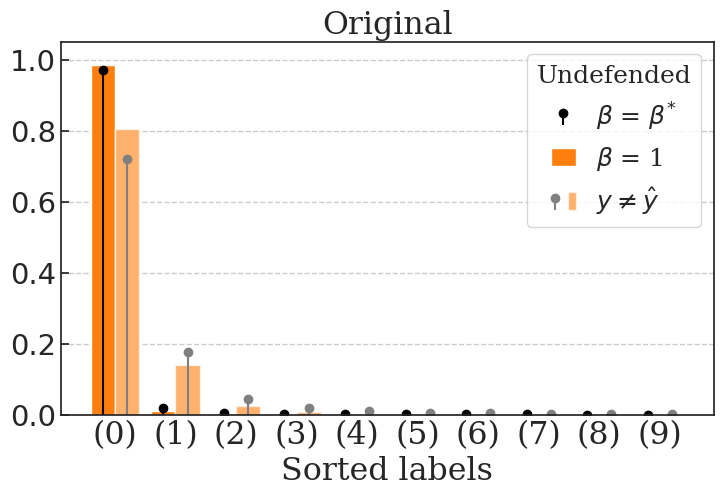

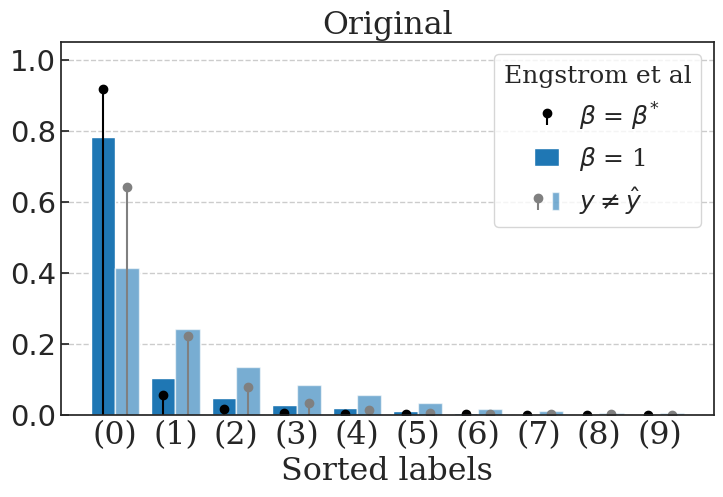

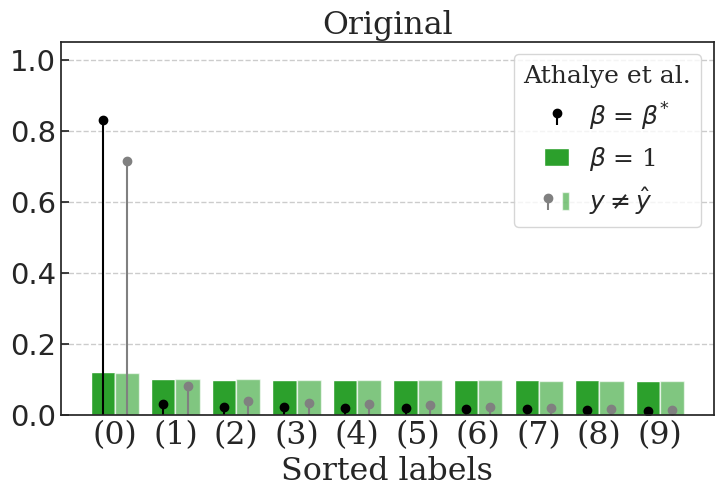

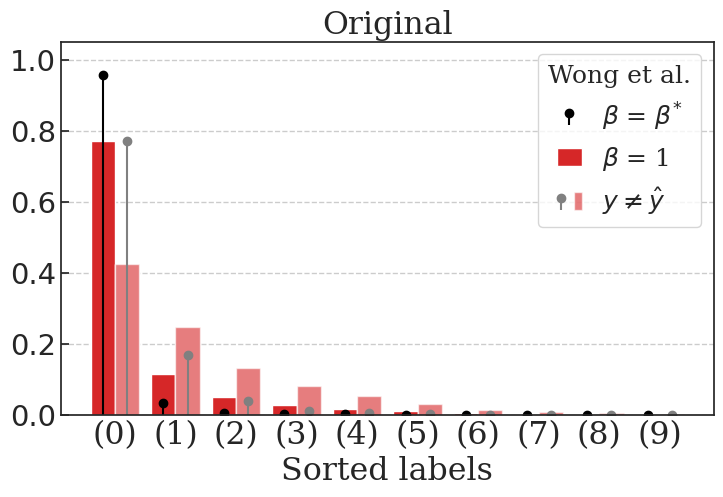

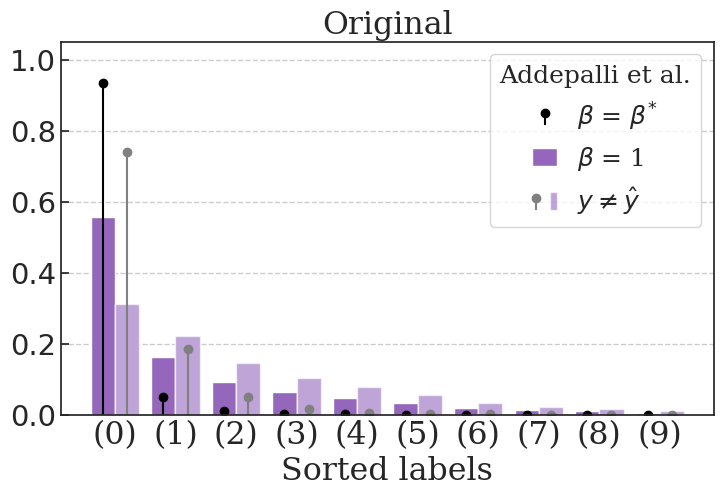

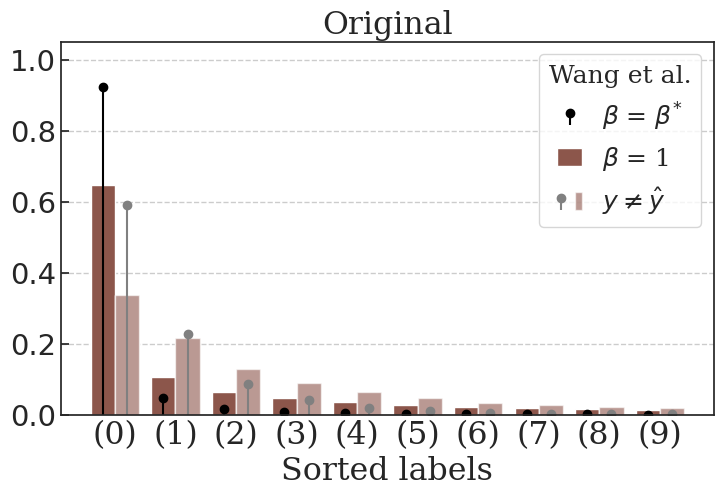

In [71]:
defenses = list(COLORS_DICT.keys())
num_defenses = len(defenses)
df = get_distribution_df(["FMN"]*num_defenses, defenses, [None]*num_defenses, truefalse = True)

entropy_df = plot_distributions_truefalse(
        df_truefalse = df,
        attack = "FMN",
        savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
        save = False,
        legend = True
)

# Here the POC for the simplified expression.

In [2]:
from collections import defaultdict

def compute_approximated_pa(df_dist, df_attack, N, eps):
    # Get the df with the distribution values
    df_gibbs = df_dist.loc[
        (df_dist["labels"].isin([0,1])),
        [
            "defense",
            "labels",
            "gibbs_orig_true_mean",
            "gibbs_orig_true_std",
            "gibbs_orig_false_mean",
            "gibbs_orig_false_std",
            "gibbs_adv_true_mean",
            "gibbs_adv_true_std"
        ]
    ]

    df_results = defaultdict(list)
    for ar in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        
        # Get the df with the performance metrics needed
        df_perf = df_attack.loc[
            (df_attack["ar"].isin(["0.0", str(ar)])),# &
            # (df_attack["epsilon"] == str(eps)),
            [
                "defense",
                "logPA",
                "ar",
                "AFR_true",
                "AFR_pred"
            ]
        ]

        for defense in defenses:
            
            tau = df_perf[(df_perf["defense"] == defense) & (df_perf["ar"] == "0.0")]["AFR_true"].item()
            rho = df_perf[(df_perf["defense"] == defense) & (df_perf["ar"] == str(ar))]["AFR_pred"].item()

            gibbs_orig_true_mean = df_gibbs[(df_gibbs["defense"] == defense) & (df_gibbs["labels"] == 0)]["gibbs_orig_true_mean"].item()
            gibbs_orig_true_std = df_gibbs[(df_gibbs["defense"] == defense) & (df_gibbs["labels"] == 0)]["gibbs_orig_true_std"].item()
            gibbs_orig_false_mean = df_gibbs[(df_gibbs["defense"] == defense) & (df_gibbs["labels"] == 0)]["gibbs_orig_false_mean"].item()
            gibbs_orig_false_std = df_gibbs[(df_gibbs["defense"] == defense) & (df_gibbs["labels"] == 0)]["gibbs_orig_false_std"].item()
            gibbs_adv_true_mean = df_gibbs[(df_gibbs["defense"] == defense) & (df_gibbs["labels"] == 0)]["gibbs_adv_true_mean"].item()
            gibbs_adv_true_std = df_gibbs[(df_gibbs["defense"] == defense) & (df_gibbs["labels"] == 0)]["gibbs_adv_true_std"].item()


            d_err = 1.0 - gibbs_orig_true_mean# + gibbs_orig_true_std
            d_mis = 1.0 - gibbs_orig_false_mean# + gibbs_orig_false_std
            d_adv = 1.0 - gibbs_adv_true_mean# + gibbs_adv_true_std

            err_term = np.log(1-2*d_err)
            mis_term = np.log(1-2*d_mis)
            adv_term = np.log(d_adv)

            pa_approx = N*(
                tau*rho*err_term + (1-tau)*rho*mis_term + tau*(1-rho)*adv_term
            )
            pa_real = df_perf[(df_perf["defense"] == defense) & (df_perf["ar"] == str(ar))]["logPA"].item()

            df_results["ar"].append(ar)
            df_results["defense"].append(defense)
            df_results["approx"].append(pa_approx)
            df_results["real"].append(pa_real)

            df_results["N*tau*rho"].append(int(N*tau*rho))
            df_results["2*d_err"].append(2*d_err)
            df_results["N*err_term"].append(tau*rho*N*err_term)

            df_results["N*(1-tau)*rho"].append(int(N*(1-tau)*rho))
            df_results["2*d_mis"].append(2*d_mis)
            df_results["N*mis_term"].append((1-tau)*rho*N*mis_term)

            df_results["N*tau*(1-rho)"].append(int(N*tau*(1-rho)))
            df_results["d_adv"].append(d_adv)
            df_results["N*adv_term"].append(tau*(1-rho)*N*adv_term)

    return pd.DataFrame(df_results)

In [19]:
def plot_approx(df_pa_approx, savedir, save: bool = False):
    _, (ax1, ax2) = plt.subplots(figsize=(4.2 * 3.861, 2 * 2.7291), nrows=1, ncols=2)
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    df_pa_approx = df_pa_approx[(~df_pa_approx["defense"].isin(["Standard", "BPDA"]))]

    for ax, pa_value, legend_bool in [(ax1, "real", False), (ax2, "approx", False)]:
        sns.lineplot(
            data=df_pa_approx,
            ax=ax,
            x="ar",
            y=pa_value,
            hue="defense",
            style="defense",
            dashes=False,
            marker="o",
            linewidth=3,
            palette=COLORS_DICT,
            legend=legend_bool
        )
        ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        ax.tick_params(axis="both", which="both", direction="in")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        ax.set_xlabel("Adversarial Ratio", fontname=fontname)
        ax.set_ylabel("PA" if pa_value == "real" else "Approx. PA", fontname=fontname)

        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)

        if pa_value == "real":
            ax.set_ylim(-2500, None)

        ax.set_title(r"FMN attack", fontname=fontname)
        ax.grid(linestyle="--")

    # handles, labels = ax1.get_legend_handles_labels()
    # ax1.legend(
    #     handles = handles,
    #     labels=[LABEL_DICT[lab] for lab in labels],
    #     loc="lower left",
    #     handlelength=0.5,
    #     prop={
    #         "family": fontname,
    #         'size': 18
    #     },
    # )
    
                
    plt.tight_layout()
    if save:
        plt.savefig(
            os.path.join(savedir, f"approx_logPA_FMN.png")
        )
        plt.clf()
    else:
        plt.show()
    plt.close()

In [21]:
defenses = list(COLORS_DICT.keys())
num_defenses = len(defenses)

N = 1e4
eps = 0.0314

# Get the df with the distributions
df_dist = get_distribution_df(["FMN"]*num_defenses, defenses, [str(eps)]*num_defenses, truefalse = True)
df_attack = _get_attack_df("FMN")


df_pa_approx = compute_approximated_pa(df_dist, df_attack, N, eps)

In [25]:
plot_approx(
    df_pa_approx,
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
    save = True
)

In [23]:
pd.options.display.float_format = '{:.2f}'.format

df_pa_approx = df_pa_approx.sort_values("real", ascending=False)
df_pa_approx.loc[
    (df_pa_approx["ar"] == 1.0),
    [
    "defense",
    "N*tau*rho",
    "2*d_err",
    "N*err_term",
    "N*(1-tau)*rho"	,
    "2*d_mis",
    "N*mis_term",
    "N*tau*(1-rho)",
    "d_adv",
    "N*adv_term",
    ]
].to_csv(r"/cluster/home/vjimenez/adv_pa_new/results/adv/approx_logPA_FMN.csv")


# df_pa_approx.to_csv(r"/cluster/home/vjimenez/adv_pa_new/results/adv/approx_logPA_PGD_0.0314.csv")

# Add a frame to the PNG adversarial plots

In [75]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image, ImageOps
import os
from IPython.display import display

def mpl_color_to_rgb(color):
    return tuple(int(x * 255) for x in mcolors.to_rgb(color))

img_name_list = ["adv_fmn"]
for img_name in img_name_list:
    img = Image.open(fr"/cluster/home/vjimenez/adv_pa_new/{img_name}.png")
    framed_img = ImageOps.expand(img, border=1, fill=mpl_color_to_rgb("red"))

    img_name += "_framed"
    framed_img.save(fr"/cluster/home/vjimenez/adv_pa_new/{img_name}.png")

# Compute the entropy

In [72]:
entropy_df_copy = entropy_df.copy()

In [73]:
entropy_df["difference"] = entropy_df["gibbs_orig_true_mean"] - entropy_df["orig_true_mean"]

In [74]:
entropy_df[["defense", "difference"]].to_csv("foo.csv")

In [32]:
# entropy_df["adv_orig_true"] = entropy_df["adv_true"] - entropy_df["orig_true"]
# entropy_df["gibbs_adv_orig_true"] = entropy_df["gibbs_adv_true"] - entropy_df["gibbs_orig_true"]
# entropy_df["adv_orig_false"] = entropy_df["adv_true"] - entropy_df["orig_false"]
# entropy_df["gibbs_adv_orig_false"] = entropy_df["gibbs_adv_true"] - entropy_df["gibbs_orig_false"]
# entropy_df["orig_false_true"] = entropy_df["orig_true"] - entropy_df["orig_false"]
# entropy_df["gibbs_orig_false_true"] = entropy_df["gibbs_orig_true"] - entropy_df["gibbs_orig_false"]

# entropy_df["diff_adv_true"] = entropy_df["adv_true"] - entropy_df["gibbs_adv_true"]
# entropy_df["diff_orig_true"] = entropy_df["orig_true"] - entropy_df["gibbs_orig_true"]
# entropy_df["diff_orig_false"] = entropy_df["orig_false"] - entropy_df["gibbs_orig_false"]


In [33]:
entropy_df["score_2"] = entropy_df["adv_orig_true"] + entropy_df["orig_false_true"]# = "adv_orig_false"
entropy_df["score_2"]

0   -0.038366
0    1.980582
0    2.604888
0    1.961990
0    2.178076
0    2.198735
Name: score_2, dtype: float32

In [27]:
entropy_df.to_csv(r'/cluster/home/vjimenez/adv_pa_new/results/adv/entropy_data.csv', index=False)

In [29]:
entropy_df

,defense,orig_true,gibbs_orig_true,orig_false,gibbs_orig_false,adv_true,gibbs_adv_true,adv_orig_true,gibbs_adv_orig_true,adv_orig_false,gibbs_adv_orig_false,diff_adv_true,diff_orig_true,diff_orig_false,orig_false_true,gibbs_orig_false_true
0,Standard,0.114921,0.115754,0.902808,0.902808,0.864443,0.867869,0.749522,0.752115,-0.038366,-0.034940,-0.003426,-0.000833,0.0,0.787887,0.787055
0,Engstrom2019Robustness,1.316392,0.109170,0.448008,0.448008,2.428589,1.118384,1.112197,1.009213,1.980582,0.670376,1.310206,1.207222,0.0,-0.868384,0.338838
0,BPDA,3.313576,0.237159,0.715278,0.715278,3.320166,1.140225,0.006590,0.903066,2.604888,0.424947,2.179941,3.076417,0.0,-2.598298,0.478120
0,Wong2020Fast,1.331364,0.100256,0.442608,0.442608,2.404598,1.102947,1.073234,1.002692,1.961990,0.660339,1.301651,1.231109,0.0,-0.888756,0.342353
0,Addepalli2021Towards_RN18,2.183971,0.160140,0.540079,0.540079,2.718154,1.260368,0.534184,1.100228,2.178076,0.720290,1.457786,2.023830,0.0,-1.643892,0.379938
0,Wang2023Better_WRN-28-10,1.927371,0.093038,0.585404,0.585404,2.784139,1.215862,0.856768,1.122824,2.198735,0.630458,1.568277,1.834333,0.0,-1.341967,0.492366


In [24]:
import pickle

# Assuming your DataFrame is called entropy_df
with open(r'/cluster/home/vjimenez/adv_pa_new/results/adv/entropy_data.pkl', 'wb') as file:
    pickle.dump(entropy_df, file)

In [25]:
import pickle

# Load the DataFrame
with open(r'/cluster/home/vjimenez/adv_pa_new/results/adv/entropy_data.pkl', 'rb') as file:
    loaded_entropy_df = pickle.load(file)

In [3]:
import matplotlib.lines as mlines

class ErrorBarHandler(object):
    def __init__(self, capsize=5):
        self.capsize = capsize

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        x0 -= 0.5
        width, height = handlebox.width, handlebox.height
        # height -= 5
        
        # Create the vertical line
        line = mlines.Line2D([x0+width/2, x0+width/2], [y0, y0+height - 1], color='black')

        # Create the horizontal cap
        cap_top = mlines.Line2D([x0+width/2-self.capsize/2 - 1, x0+width/2+self.capsize/2], 
                            [y0+height, y0+height], color='black', lw=1)
        cap_bottom = mlines.Line2D([x0+width/2-self.capsize/2 - 1, x0+width/2+self.capsize/2], 
                            [y0, y0], color='black', lw=1)
        
        handlebox.add_artist(line)
        handlebox.add_artist(cap_top)
        handlebox.add_artist(cap_bottom)
        return line

In [32]:
EPSILON_DICT = {
    "0.0314": "8 / 255",
    "0.0627": "16 / 255",
    "0.1255": "32 / 255",
}

def plot_distributions_truefalse_0(
        df_truefalse: pd.DataFrame,
        savedir: str,
        save: bool = False,
        legend: bool = False,
        save_appendix: str = ""
    ):

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    attack = df_truefalse["attack"].unique()[0].upper()

    epsilon = df_truefalse["epsilon"].unique()[0]
    epsilon_parsed = EPSILON_DICT[epsilon] if epsilon != None else None

    for defense in df_truefalse["defense"].unique():
        _, ax = plt.subplots(figsize=(1.2 * 3.861, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")

        level_set = df_truefalse[df_truefalse["defense"] == defense].sort_values("labels").iloc[0]
        color = COLORS_DICT[level_set['defense']]


        delta = 0.2
        x_source = np.array([0,1,2])
        y_beta_1 = [level_set['orig_true_mean'].item(), level_set['orig_false_mean'].item(), level_set['adv_true_mean'].item()]
        h1 = ax.bar(x_source - delta, y_beta_1, width=0.4, color=color) 

        err_beta_1 = [level_set['orig_true_std'].item(), level_set['orig_false_std'].item(), level_set['adv_true_std'].item()]
        ax.bar(
            x = x_source - delta,
            align = "center",
            height = y_beta_1,
            facecolor='none',
            edgecolor='none',
            color='black',
            yerr=[
                err if y+err <= 1 else 1-y
                for err, y in zip(err_beta_1, y_beta_1)
            ],
            capsize=3
        )
        
        y_beta_gibbs = [level_set['gibbs_orig_true_mean'].item(), level_set['gibbs_orig_false_mean'].item(), level_set['gibbs_adv_true_mean'].item()]
        ax.bar(x_source + delta, y_beta_gibbs, width=0.4, hatch="/", color="white") # white to block grid
        h2 = ax.bar(x_source + delta, y_beta_gibbs, width=0.4, alpha=0.6, hatch="/", color=color) 

        err_beta_gibbs = [level_set['gibbs_orig_true_std'].item(), level_set['gibbs_orig_false_std'].item(), level_set['gibbs_adv_true_std'].item()]

        ax.bar(
            x = x_source + delta,
            align = "center",
            height = y_beta_gibbs,
            facecolor='none',
            edgecolor='none',
            color='black',
            yerr=np.asarray([
                [err, err] if y+err <= 1 else [err, 1-y]
                for err, y in zip(err_beta_gibbs, y_beta_gibbs)
            ]).T,
            capsize=3
        )
         
        # ax.set_xticklabels([
        #     r"$\mathbf{P}(\hat{y} \mid \mathbf{x}^\prime, \hat{y} = y)$",
        #     r"$\mathbf{P}(\hat{y} \mid \mathbf{x}^\prime, \hat{y} \neq y)$",
        #     r"$\mathbf{P}(\hat{y} \mid \mathbf{x}^{\prime \prime}, \hat{y} \neq y)$"
        # ])
        # ax.set_xticklabels([
        #     r"$\mathbf{P}_{\hat{y} =y}^{\mathbf{x}^\prime}(\hat{y})$",
        #     r"$\mathbf{P}_{\hat{y} \neq y}^{\mathbf{x}^\prime}(\hat{y})$",
        #     r"$\mathbf{P}_{\hat{y} \neq y}^{\mathbf{x}^{\prime \prime}}(\hat{y})$"
        # ])

        ax.set_xticks([0,1,2])
        ax.set_xticklabels([
            r"$\hat{y}^\prime = y}$" + "\n" + r"$\mathbf{x}^\prime$",
            r"$\hat{y}^\prime \neq y}$" + "\n" + r"$\mathbf{x}^\prime$",
            r"$\hat{y}^{\prime\prime} \neq \hat{y}^\prime}$" + "\n" + r"$\mathbf{x}^{\prime \prime}$"
        ])
        ax.tick_params(axis="both", which="both", direction="in")
        ax.tick_params(axis='x', length=0) # hide ticks
        # plt.xticks(rotation=45)

        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)
            tick.set_fontsize(16)

        # 
        # ax.axhline(0.0, color="black", lw=3, ls="--", label=r"$\beta = 0$")
        ax.set_yticks(np.arange(0.0, 1.2, 0.2))
        ax.set_ylim(0.0, 1.15)
        ax.grid(linestyle="--", axis="y")

        error_bar = mlines.Line2D([], [], color='black')
        handles = [h1, h2] #, error_bar]
        labels = [r"$\beta$ = 1", r"$\beta$ = $\beta^{*}$"] #, r"$\sigma$"]
        ax.legend(
            # title=LABEL_DICT[defense],
            handles = handles,
            labels=labels,
            loc="upper right",
            handlelength=1.0,
            handler_map={
                mlines.Line2D: ErrorBarHandler(capsize=8),
            },
            prop={
                "family": fontname,
                'size': 14,
            },
        )
        # legend.get_title().set_fontsize(18)
        # legend.get_title().set_fontname(fontname)
        
        
        ax.set_title(LABEL_DICT[defense], fontname=fontname)

        ax.set_ylabel(r"Avg. prediction confidence", fontname=fontname)

        plt.tight_layout()
        if save:
            if attack == "PGD":
                savepath = os.path.join(savedir, defense, f"{defense}_3_PGD_{epsilon}{save_appendix}.pdf")  
            else:
                savepath = os.path.join(savedir, defense, f"{defense}_3_FMN{save_appendix}.pdf")

            plt.savefig(savepath, dpi=300)
            plt.clf()
        else:
            plt.show()
        plt.close()

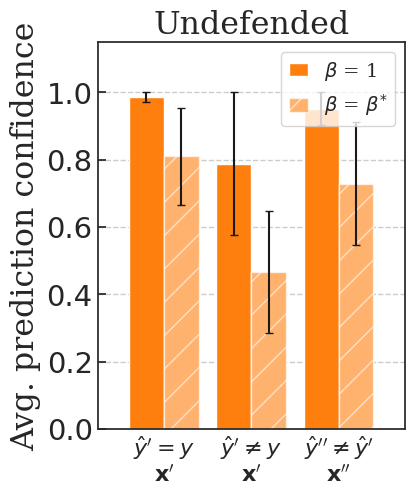

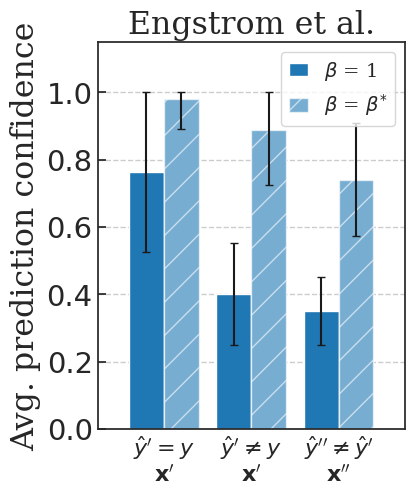

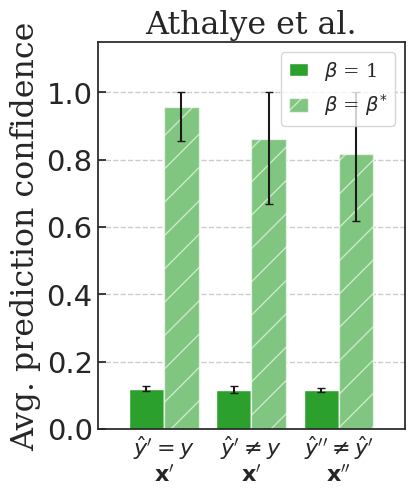

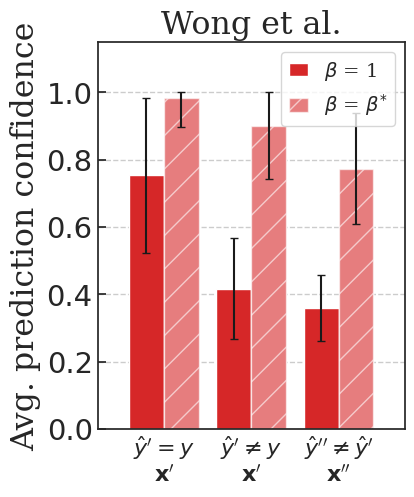

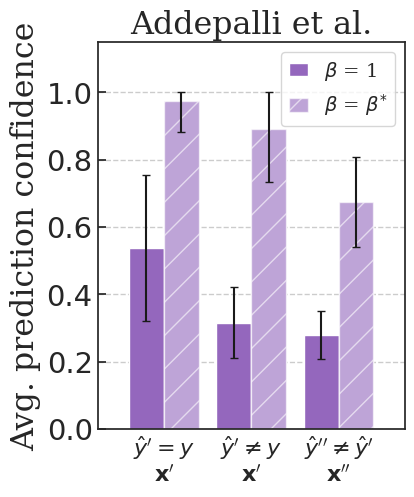

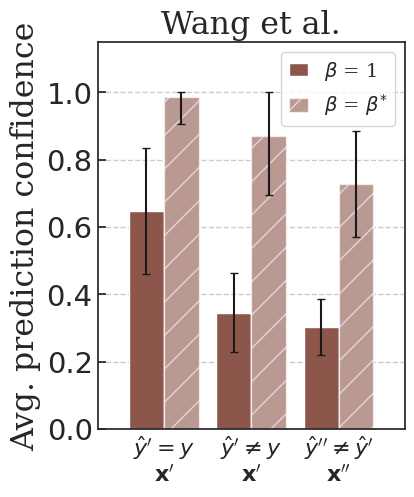

In [40]:
defenses = list(COLORS_DICT.keys())
num_defenses = len(defenses)

attack = "FMN"
epsilon = None

attack = "PGD"
epsilon = "0.1255"

# for epsilon in ["0.0314", "0.0627", "0.1255"]:
# epsilon = None "0.1255"

# defenses = ["Standard"]
df = get_distribution_df(
    [attack]*num_defenses,
    defenses,
    [epsilon]*num_defenses,
    ar="1.0"
)
plot_distributions_truefalse_0(
        df_truefalse = df,
        savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
        save = False,
        legend = False,
        save_appendix = "_ar=1.0"
)

In [53]:
PARSE_EPS = {
    "0.0314": "8 / 255",
    "0.0627": "16 / 255",
    "0.1255": "32 / 255",
}

def plot_distributions_truefalse_1(
        df_truefalse: pd.DataFrame,
        df_afr: pd.DataFrame,
        attack: str,
        savedir: str,
        save: bool = False,
        save_appendix: str = ""
    ):

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    fontsize, fontsize_title = 16, 18

    num_defenses = len(df_truefalse["defense"].unique())
    epsilon = df["epsilon"].unique().item()

    _, ax = plt.subplots(figsize=(0.5 * num_defenses * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")
    
    for idef, defense in enumerate(df_truefalse["defense"].unique()):
        # Additional values to compute:
        accuracy_original = df_afr.loc[
            (df_afr["defense"] == defense) & (df_afr["ar"] == "0.0"),
            ["AFR_true"]
        ].values[0].item()

        # accuracy_perturbed = df_afr.loc[
        #     (df_afr["defense"] == defense) & (df_afr["ar"] == "1.0"),
        #     ["AFR_true"]
        # ].values[0].item()

        # afrp = df_afr.loc[
        #     (df_afr["defense"] == defense) & (df_afr["ar"] == "1.0"),
        #     ["AFR_pred"]
        # ].values[0].item()

        level_set = df_truefalse[df_truefalse["defense"] == defense].sort_values("labels").iloc[0]
        color = COLORS_DICT[level_set['defense']]


        delta, barwidth = 0.175, 0.35
        pos_x = idef - idef*0.2
        first_mean = accuracy_original * level_set['orig_true_mean'].item() + (1-accuracy_original) * level_set['orig_false_mean'].item()
        first_std = accuracy_original * level_set['orig_true_std'].item() + (1-accuracy_original) * level_set['orig_false_std'].item()

        x_beta_1, y_beta_1, err_beta_1 = [pos_x - delta], [first_mean], [first_std]
        h1 = ax.bar(x_beta_1, y_beta_1, width=barwidth, color=color) 
        ax.bar(
            x = x_beta_1,
            align = "center",
            height = y_beta_1,
            facecolor='none',
            edgecolor='none',
            color='black',
            yerr=[
                err if y+err <= 1 else 1-y
                for err, y in zip(err_beta_1, y_beta_1)
            ],
            capsize=3
        )
        

        x_beta_2, y_beta_2, err_beta_2 = [pos_x + delta], [level_set['adv_true_mean'].item()], [level_set['adv_true_std'].item()]
        ax.bar(x_beta_2, y_beta_2, width=barwidth, color="white") # to hide the lines behiind
        h2 = ax.bar(x_beta_2, y_beta_2, width=barwidth, alpha=0.6, hatch="/", color=color) 
        ax.bar(
            x = x_beta_2,
            align = "center",
            height = y_beta_2,
            facecolor='none',
            edgecolor='none',
            color='black',
            yerr=np.asarray([
                [err, err] if y+err <= 1 else [err, 1-y]
                for err, y in zip(err_beta_2, y_beta_2)
            ]).T,
            capsize=3
        )

    # Create a legend
    handles = [
        ax.bar([num_defenses + 10], [0.5], width=barwidth, color="tab:gray"),
        ax.bar([num_defenses + 10], [0.5], width=barwidth, alpha=0.6, hatch="/", color="tab:gray") 
    ]
    # labels = [
    #     r"$\mathbf{P}(\hat{y}^\prime \mid \mathbf{x}^\prime, \hat{y}^\prime = y)$",
    #     r"$\mathbf{P}(\hat{y}^{\prime \prime} \mid \mathbf{x}^{\prime \prime}, \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
    # ]
    labels = [
        r"$p(\hat{y}^\prime \mid X^\prime, \hat{y}^\prime = y)$",
        r"$p(\hat{y}^{\prime \prime} \mid X^{\prime \prime}, \hat{y}^{\prime \prime} \neq \hat{y}^{\prime})$"
    ]
    ax.legend(
        # title=LABEL_DICT[defense],
        handles = handles,
        labels=labels,
        loc="upper right",
        handlelength=1.5,
        prop={
            "family": fontname,
            'size': 13,
        },
    )

    # Finish the plot:
    ax.set_xticks(list(range(num_defenses)))
    ax.set_xticklabels([
        # LABEL_DICT[defense] 
        None
        for defense in df_truefalse["defense"].unique()
    ])
    ax.tick_params(axis="both", which="both", direction="in")
    ax.tick_params(axis='x', length=0) # hide ticks
    plt.xticks(rotation=45)

    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)
        tick.set_fontsize(fontsize)

    ax.set_yticks(np.arange(0.0, 1.2, 0.2))
    ax.set_ylim(0.0, 1.05)
    ax.set_xlim(-barwidth - delta, (num_defenses - 1 - 0.2*(num_defenses - 1)) + delta + barwidth)
    ax.grid(linestyle="--", axis="y")
    
    # ax.set_title(LABEL_DICT[defense], fontname=fontname)
    ax.set_ylabel(r"Avg. predictive confidence", fontname=fontname)
    if attack == "PGD":
        ax.set_title(fr"{attack}, $\ell_\infty$ = {PARSE_EPS[epsilon]}", fontname=fontname) #, fontsize=20)
    else:
        ax.set_title("FMN", fontname=fontname)
        
    plt.tight_layout()
    if save:
        if attack == "PGD":
            savepath = os.path.join(savedir, f"6post_PGD_{epsilon}{save_appendix}.pdf")
        else:
            savepath = os.path.join(savedir, f"6post_FMN{save_appendix}_ar=1.0.pdf")
        plt.savefig(savepath, dpi=300)
        plt.clf()
    else:
        plt.show()
    plt.close()

In [60]:
# Get the defenses to be plotted
defenses = list(COLORS_DICT.keys())

# defenses = ["Standard", 'Wang2023Better_WRN-28-10', "BPDA"]
# defenses = ['Engstrom2019Robustness', 'Wong2020Fast', 'Addepalli2021Towards_RN18']
defenses = ['Standard', 'Engstrom2019Robustness', 'Wong2020Fast', 'Wang2023Better_WRN-28-10', 'Addepalli2021Towards_RN18', 'BPDA']
ar = "1.0" # assumed

# Specify attack:
attack = "PGD"

# Specify epsilon:
epsilon = "0.1255"
# epsilon = None

# Get the values of AFRP(1.0) and AFRT(0.0).
df = _get_attack_df(attack)
df_afr = df.loc[
    (df["attack"] == attack) &
    (df["defense"].isin(defenses)) &
    (df["ar"].isin([ar, "0.0"])) &
    (df["epsilon"] == epsilon),
    ["defense", "ar", "AFR_pred", "AFR_true"]
]

# Get the distribution df
num_defenses = len(defenses)
df = get_distribution_df([attack]*num_defenses, defenses, [epsilon]*num_defenses)

In [61]:
plot_distributions_truefalse_1(
        df_truefalse = df,
        df_afr = df_afr,
        attack = attack,
        savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
        save = True,
        save_appendix = ""
)        

In [41]:
def plot_distributions_truefalse_0_indication(
        df_truefalse: pd.DataFrame,
        attack: str,
        savedir: str,
        save: bool = False,
        legend: bool = False
    ):

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    for defense in df_truefalse["defense"].unique():
        _, ax = plt.subplots(figsize=(1.2 * 3.861, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")

        level_set = df_truefalse[df_truefalse["defense"] == defense].sort_values("labels").iloc[0]
        color = COLORS_DICT[level_set['defense']]


        x_source = np.array([0,1,2])
        y_beta_1 = np.asarray([level_set['gibbs_orig_true_mean'].item(), level_set['gibbs_orig_false_mean'].item(), level_set['gibbs_adv_true_mean'].item() + 0.1])
        ax.bar(
            x_source,
            y_beta_1,
            width=0.6,
            color="limegreen",
            # edgecolor="limegreen",
            alpha=0.5,
        ) 
        list_text = [
            r"$\mathbf{P}^{*}(\hat{y}^\prime \mid \mathbf{x}^\prime, \hat{y}^{\prime \prime} = \hat{y}^\prime = y)$",
            r"$\mathbf{P}^{*}(\hat{y}^\prime \mid \mathbf{x}^\prime, \hat{y}^{\prime \prime} = \hat{y}^\prime \neq y)$",
            r"$\mathbf{P}^{*}(\hat{y}^{\prime \prime} \mid \mathbf{x}^{\prime \prime}, \hat{y}^{\prime \prime} \neq \hat{y}^\prime)$"
        ]
        list_y0 = np.asarray([0,0,0]) + 0.015
        for text, y0, x0 in zip(list_text, list_y0, x_source):
            ax.annotate(text,
                xy=(x0, y0),
                xytext=(0, 0),
                # xycoords='axes fraction',
                textcoords='offset points',
                rotation=90,
                va='bottom',
                ha='center',
                fontname=fontname
            )

        ax.bar(
            x_source,
            height=1.0 - y_beta_1,
            bottom=y_beta_1,
            width=0.6,
            color="red",
            # edgecolor="red",
            alpha=0.5,
            # hatch="//",
            # linestyle="--",
            # linewidth=2
        ) 
        list_text = [r"$\delta_{ERR}$", r"$\delta_{MIS}$", r"$\delta_{ADV}$"]
        list_y0 = list(
            y_beta_1 + np.asarray([0.02, 0.015, 0.12])
        )
        for text, y0, x0 in zip(list_text, list_y0, x_source):
            ax.annotate(text,
                xy=(x0, y0),
                xytext=(0, 0),
                # xycoords='axes fraction',
                textcoords='offset points',
                rotation=0,
                va='bottom',
                ha='center',
                fontsize=15
            )

        ax.set_yticks([0, 1])
        ax.set_yticklabels([0, 1])

        ax.set_xticks([0,1,2])
        ax.set_xticklabels([])
        ax.tick_params(axis="both", which="both", direction="in")
        ax.tick_params(axis='x', length=0) # hide ticks

        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)
            tick.set_fontsize(fontsize)

        
        ax.set_ylim(0.0, 1.08)
        ax.set_xlim(-0.5, 2.5)
        ax.set_title(r"Avg. conditional $\mathbf{P}(\hat{y}; \beta^{*})$", fontname=fontname)

        plt.tight_layout()
        if save:
            plt.savefig(
                os.path.join(savedir, f"demonstration.png")
            )
            plt.clf()
        else:
            plt.show()
        plt.close()

NameError: name 'fontsize' is not defined

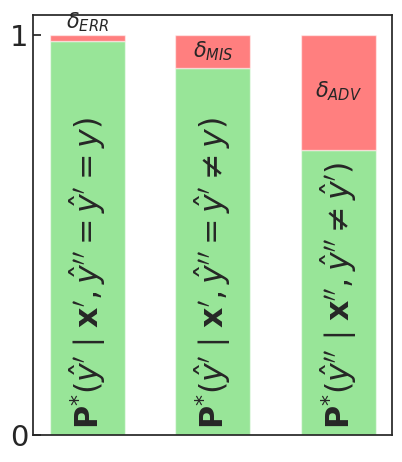

In [43]:
defenses = ["Engstrom2019Robustness"]
df = get_distribution_df(["PGD"], defenses, ["0.0314"])

plot_distributions_truefalse_0_indication(
        df_truefalse = df,
        attack = "PGD",
        savedir = r"/cluster/home/vjimenez/adv_pa_new/results/adv",
        save = False,
        legend = False
)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def min_max_scale_anda_weight(metric1, metric2):
    # Initialize two separate scalers with different feature ranges
    scaler1 = MinMaxScaler(feature_range=(-1, 0))  # For metric1
    scaler2 = MinMaxScaler(feature_range=(0, 1))   # For metric2
    
    metric1_reshaped = np.array(metric1).reshape(-1, 1)
    metric2_reshaped = np.array(metric2).reshape(-1, 1)
    
    metric1_scaled = scaler1.fit_transform(metric1_reshaped).flatten()
    metric2_scaled = scaler2.fit_transform(metric2_reshaped).flatten()
    
    return metric1_scaled * metric2_scaled

def z_score_scale_and_weight(metric1, metric2):
    scaler = StandardScaler()
    metric1_reshaped = np.array(metric1).reshape(-1, 1)
    metric2_reshaped = np.array(metric2).reshape(-1, 1)
    
    metric1_scaled = scaler.fit_transform(metric1_reshaped).flatten()
    metric2_scaled = scaler.fit_transform(metric2_reshaped).flatten()
    
    return metric1_scaled * metric2_scaled

def log_transform_and_weight(metric1, metric2):
    # For metric1, we'll use the absolute value before log transform
    metric1_transformed = np.log1p(np.abs(metric1))
    metric2_transformed = np.log1p(metric2)
    
    return metric1_transformed * metric2_transformed

def decimal_scale_and_weight(metric1, metric2):
    metric1_scaled = np.array(metric1) / np.max(np.abs(metric1))
    metric2_scaled = np.array(metric2) / np.max(np.abs(metric2))
    
    return metric1_scaled * metric2_scaled

def robust_scale_and_weight(metric1, metric2):
    scaler = RobustScaler()
    metric1_reshaped = np.array(metric1).reshape(-1, 1)
    metric2_reshaped = np.array(metric2).reshape(-1, 1)
    
    metric1_scaled = scaler.fit_transform(metric1_reshaped).flatten()
    metric2_scaled = scaler.fit_transform(metric2_reshaped).flatten()
    
    return metric1_scaled * metric2_scaled

def normalize_column(column):
    return (column - column.min()) / column.max() 

def normalize_cs(column):
    return (column - column.min()) / column.max() 

In [ ]:
df_plot = df[
    (df["attack"] == "GAUSSIAN") & 
    (df["defense"] == "Standard")# & #(df["defense"] != "BPDA") &
    # (df["epsilon"] == "0.1255")
]
metric = "logPA"

COLORS_DICT_eps = {
    "0.0314": "tab:blue",
    "0.0627": "tab:orange",
    "0.1255": "tab:green"
}

_, ax = plt.subplots(figsize=(10,6))
_, ax2 = plt.subplots(figsize=(10,6))
for eps in df_plot["epsilon"].unique():

    normalized_fid = normalize_column(df_plot['FID'])
    normalized_fid.index = df_plot.index 
    df_plot['FID_normalized'] = normalized_fid

    normalized_cs = normalize_column(df_plot['CS'])
    normalized_cs.index = df_plot.index 
    df_plot['CS_normalized'] = normalized_cs

    df_plot2 = df_plot[df_plot["epsilon"] == eps]
    adjusted_cd = 1.0 - np.asarray(df_plot2["CD"][::-1].tolist())

    fid_vec = np.asarray(df_plot2["CS_normalized"][::-1].tolist())
    fid_adj = 1 - fid_vec


    ax.plot(df_plot2["ar"][::-1], df_plot2["logPA"][::-1], marker='o', label=eps, color=COLORS_DICT_eps[eps])

    # ax2.plot(df_plot2["ar"][::-1], [0.0] + df_plot2["FID"][::-1], marker='o', label=d)
    # ax2.plot(df_plot2["ar"][::-1][0:], df_plot2["CD"][::-1], marker='o', label=d, color=COLORS_DICT[d])

    
    # import ipdb; ipdb.set_trace()
    # mmd = np.asarray(df_plot2["CD"][::-1])
    # ax2.plot(np.asarray(df_plot2["ar"][::-1][0:].tolist()),
    #          np.asarray(df_plot2["logPA"][::-1])*(mmd/max(mmd)),
    #         # min_max_scale_and_weight(
    #         #     df_plot2["logPA"][::-1],
    #         #     df_plot2["CS"][::-1]
    #         # ),
    #         marker='o',
    #         label=d,
    #         color=COLORS_DICT[d]
    #     )

ax.set_yscale('linear') 
ax.legend(loc="best", fontsize=5)
# ax2.set_yscale("linear") 
# ax2.legend(loc="best", fontsize=5)
plt.show()

In [ ]:
df.head()